## Data quality selection notebook

This run selection tool looks for good quality runs for the requested sky region, range of zenith and NSB conditions (NOTE: the default selection cuts are valid for low NSB observations).

The default cuts are to some extent, arbitrary - obviously, runs which barely fail to be selected are not totally useless... so, depending on the goal of an analysis it may be wise to relax (or tighten) the selection. For example, cuts could be softer if the goal is just source detection.

The default cuts set below are intended to provide a good quality low-NSB sample for flux calculations (energy spectrum, light curve), while keeping systematic errors related to variable performance an atmospheric conditions at an *acceptable* level. The selection is not the same as in the LST1 performance paper (ApJ 956), but it should provide data of about the same quality.

Note that the selection here is performed at the run level but, as can be clearly seen below, we could benefit of a selection at the level of a subrun, or even based on shorter time periods (the approach that will be followed by CTA). This however is probably something to be introduced at a higher stage of the analysis, likely in the DL2 to DL3 stage

### Cosmics intensity spectra
the selection is based on the **differential intensity spectra of the detected showers, dR/dI (events / s / p.e.)** , where intensity is the image intensity, total number of p.e. in pixels which survive image cleaning.
These spectra are computed on a subrun-wise basis (as part of the DL1 data check). The idea is that at intensities well above the camera threshold, the rate of cosmics, for optimal atmospheric conditions and nominal telescope performance, should depend mainly on the telescope pointing (with perhaps some small yearly modulation due to seasonal atmospheric variations). If, all other things being equal, we modify the amount of recorded light (e.g. because of a lower telescope throughput, or a higher-than-usual atmospheric absorption) we will not record fewer "high-intensity" showers (unless the reduction of light is so strong as to go all the way down to the threshold): all those high-intensity showers will still trigger, but will be recorded at a lower intensity. The dR/dI spectrum in that high-intensity region will shift to lower values.

We have characterized the high-intensity dR/dI spectra with a power-law fit between 316 and 562 p.e. (these are edges of the intensity histogram binning in the DL1 data check). The fit parameters (normalization and index) have clear zenith-distance dependencies that we have corrected, to get "ZD=0-equivalent" values. We then compute, from this ZD-corrected fits, the value of dR/dI in the middle of the fit range (422 p.e.). This value, and the power-law index, are used to judge whether a given run looks "of good quality" or not. 

Since we have these parameters for every subrun, we also use their variability of the quantities through a run as a proxy for data quality. We obtain a Lomb-Scargle periodogram of dR/dI@422 p.e. to spot runs with unstable behaviour (could be due for example to the MAGIC LIDAR, or other external sources of light).


### Outline of the selection procedure:

* The user sets 
    * the desired Sky Region (e.g. for wobble observations of a given source)
    * the range of dates (in YYYYMMDD format)
    * the zenith distance range
    * the maximum allowed NSB level

Then the following additional criteria are used to determine what a good run is:

* the run must contain interleaved flatfield and pedestal events (only runs with no interleaved **at all** are rejected)
<br>

* the pointing (in sky coordinates) must be stable (details can be found below)
<br>
* the mean P-value of the dR/dI power-law fit (for all subruns in a run) must be above a given threshold (to exclude bad fits). The cut value depends on the number of subruns, see details later in the notebook.
<br>
* the maximum amplitude of the Lomb-Scargle periodogram of dR/dI@422 p.e. through the run must be below a given value (just to exclude very unstable runs). NOTE: some high values may be due to the periodic shots of the MAGIC LIDAR, in that case they might be recoverable, since down the pipeline the LIDAR-induced events are very gamma-unlike and easily identified.
<br>
* the fitted power-law index of dR/dI (mean in run) must be within a given range (see default cut values later in the notebook)
<br>
* dR/dI@422 p.e. (mean in run) must above a certain value (1.5 events/s/p.e. by default), and 80% of the subrun-wise values must be contained in a range of 0.15 around the most frequent value (mode) in the run.
<br>
* note that no cut is by default performed on the camera trigger threshold (estimated via the so-called intensity threshold, the value of intensity for which dR/dI reaches 50% of its peak value). Even if the threshold is high (for whatever reason), the data may still be perfectly healthy and valid for computing 


Optimistic note: if we ever have data in which the event rate is dominated by gammas, one should be careful with the data selection... the assumption is that the rate of cosmics is **completely dominated by protons** and other nuclei!


In [1]:
import pandas as pd
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.stats import binned_statistic
from scipy.signal import lombscargle

## Load all the necessary datacheck files

In [2]:
# The sample of night-wise datacheck files from 20191123 to 20231119 is ~2.9 GB 
files = glob.glob("/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck*.h5")
files.sort()

In [3]:
# This takes a few minutes... DON'T RUN IT MORE THAN ONCE, it is not needed! (If you change the 
# sky region or the cuts just execute the cells from "Data selection configuration" onwards)
dummy = []
dummy2 = []
for i, file in enumerate(files):
    if i%10 == 0:
        print(i, '/', len(files), file)
    dummy.append(pd.read_hdf(file, 'cosmics_intensity_spectrum'))
    dummy2.append(pd.read_hdf(file, 'runsummary'))
    
# cosmics intensity spectra table (subrun-wise):
cis = pd.concat(dummy, ignore_index=True)

# parameters computed run-wise:
runsummary = pd.concat(dummy2, ignore_index=True)

0 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20191123.h5
10 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20200131.h5
20 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20200618.h5
100 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210321.h5
110 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210420.h5
120 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210512.h5
130 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210604.h5
140 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210702.h5
150 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_20210712.h5
160 / 489 /fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datach

In [248]:
cis.columns

Index(['yyyymmdd', 'ra_tel', 'dec_tel', 'cos_zenith', 'az_tel', 'runnumber',
       'subrun', 'time', 'elapsed_time', 'corrected_elapsed_time',
       'cosmics_rate', 'cosmics_cleaned_rate', 'intensity_at_half_peak_rate',
       'ZD_corrected_intensity_at_half_peak_rate', 'cosmics_peak_rate',
       'ZD_corrected_cosmics_peak_rate', 'cosmics_rate_at_422_pe',
       'ZD_corrected_cosmics_rate_at_422_pe', 'cosmics_spectral_index',
       'ZD_corrected_cosmics_spectral_index', 'intensity_spectrum_fit_p_value',
       'intensity_at_reference_rate', 'diffuse_nsb_std',
       'num_star_affected_pixels', 'anomalous_low_intensity_peak'],
      dtype='object')

In [249]:
runsummary.columns

Index(['runnumber', 'time', 'elapsed_time', 'min_altitude', 'mean_altitude',
       'max_altitude', 'min_azimuth', 'max_azimuth', 'mean_azimuth', 'mean_ra',
       'mean_dec', 'num_cosmics', 'num_pedestals', 'num_flatfield',
       'num_unknown_ucts_trigger_tags', 'num_wrong_ucts_tags_in_cosmics',
       'num_wrong_ucts_tags_in_pedestals', 'num_wrong_ucts_tags_in_flatfield',
       'num_ucts_jumps', 'num_unknown_tib_trigger_tags',
       'num_wrong_tib_tags_in_cosmics', 'num_wrong_tib_tags_in_pedestals',
       'num_wrong_tib_tags_in_flatfield', 'num_pedestals_after_cleaning',
       'num_contained_mu_rings', 'ff_charge_mean', 'ff_charge_mean_err',
       'ff_charge_stddev', 'ff_time_mean', 'ff_time_mean_err',
       'ff_time_stddev', 'ff_rel_time_stddev', 'ped_charge_mean',
       'ped_charge_mean_err', 'ped_charge_stddev',
       'ped_fraction_pulses_above10', 'ped_fraction_pulses_above30',
       'cosmics_fraction_pulses_above10', 'cosmics_fraction_pulses_above30',
       'mu_effi_m

In [250]:
# Obtain list of runnumbers and corresponding dates:
runlist, iix = np.unique(cis['runnumber'], return_index=True)
rundate = cis['yyyymmdd'][iix].to_numpy()

## We will now compute some run-wise quantities from the subrun-wise table entries  

In [251]:
#
# Lomb-Scargle periodogram of ZD_corrected_cosmics_rate_at_422_pe vs. time
# May eventually be useful to identify runs affected by MAGIC LIDAR shots...
#

max_lsc = []
max_lsc_period = [] # in seconds
for i, ri in enumerate(runlist):
    if i%1000 == 0:
        print(i, '/', len(runlist))
    rvalues = cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==ri].to_numpy()
    tvalues = cis['time'][cis['runnumber']==ri].to_numpy()
    tvalues -= tvalues[0]
    freqs = np.logspace(-3, -1, 100)
    #freqs = np.linspace(0.01, 0.1, 100)
    mask = ~np.isnan(rvalues)
    lsc = lombscargle(tvalues[mask], rvalues[mask], freqs, 
                      normalize=True, precenter=True)
    max_lsc.append(np.nanmax(lsc))
    if (~np.isnan(lsc)).sum() == 0:
        max_lsc_period.append(np.nan)
    else:
        max_lsc_period.append(1./freqs[np.nanargmax(lsc)])

max_lsc = np.array(max_lsc)
max_lsc_period = np.array(max_lsc_period)

# You may get some RuntimeWarnings, from rare data with big issues - can be safely ignored

0 / 6952


/fefs/aswg/workspace/abelardo.moralejo/miniconda3/envs/lst-dev/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:147: RuntimeWarning: Mean of empty slice.
  pgram = _lombscargle(x, y - y.mean(), freqs)
/fefs/aswg/workspace/abelardo.moralejo/miniconda3/envs/lst-dev/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/fefs/aswg/workspace/abelardo.moralejo/miniconda3/envs/lst-dev/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  pgram *= 2 / np.dot(y, y)
/tmp/ipykernel_27270/1644784293.py:19: RuntimeWarning: All-NaN slice encountered
  max_lsc.append(np.nanmax(lsc))


1000 / 6952
2000 / 6952
3000 / 6952
4000 / 6952
5000 / 6952
6000 / 6952


## ****************   Data selection configuration   ****************
For a standard selection of dark-night data, just set the desired source coordinates, the zenith angle range (if desired), and the time span of the data in YYYYMMDD. All the rest can be kept at the default values.
## Basic cuts: 

In [252]:
# Select only runs with in which both types of interleaved events are present:
require_interleaved_pedestals = True
require_interleaved_flatfield = True

## Put source coordinates below (if set to None, all data will be used)

In [253]:
#source_coordinates = None
source_coordinates = SkyCoord.from_name("Crab Nebula")
print(source_coordinates)

# Select here the desired range of telescope pointings around the source. 
# The values below are for standard wobble observations (0.4 deg source offset)
min_angle_to_source = 0.35 * u.deg
max_angle_to_source = 0.45 * u.deg

<SkyCoord (ICRS): (ra, dec) in deg
    (83.6287, 22.0147)>


## Pointing stability (maximum allowed std dev of declination in run)

In [254]:
max_pointing_dec_std = 0.01 # deg

## Zenith angle range

In [255]:
# Just an example, use whatever you need
min_zenith = 0 * u.deg
max_zenith = 35 * u.deg

## Maximum diffuse NSB (average std dev of pedestals in pixels with no nearby bright star)

In [256]:
max_diffuse_nsb_std = 2.1 # p.e. A value of 2.1 roughly corresponds to selecting moon-less data 

## Range of dates YYYYMMDD ("date before midnight" convention) 

In [257]:
# first_date = 0         # no selection
# last_date  = 29990101  # no selection

# Both first_date and last_date are included in the selection:

first_date = 20201101
last_date  = 20220415

# Very stable period: 20221118 - 20230214

## Selection based on the dR/dI, differential cosmics rate (in intensity), i.e. "Cherenkov transparency"
As part of the DL1 data checks, dR/dI was fitted to a power-law between 316-562 p.e. (the funny values are due to the binning used in the DL1 datacheck to store the intensity histograms). The fit parameters were then "converted" to their ZD=0 equivalent, i.e. we apply a zenith-dependent correction so the values for good data are all around the same values.

Then we use the (ZD-corrected) power-law index at 422 p.e., and the (ZD-corrected) vaue of dR/dI (events per second and per p.e.) at 422 p.e. as quantities for the quality selection.

In [258]:
# We make a fit per subrun. Then we average the fit p-values. For good fits the pdf of P us uniform in [0,1]
# The mean will have mean 0.5 and std dev 1/sqrt(12*Nsubruns). 
# We require a minimum value of (mean_p-0.5)*sqrt(12*Nsubruns) (in the limit of large Nsubruns would be a standard
# gaussian of mean 0 and std dev 1)

min_mean_fit_p = -3.

# Lomb Scargle periodogram, to detect strange features in the dR/dI evolution within a run
max_LS_periodogram_maxamplitude = 1e-2

min_drdi_index = -2.35
max_drdi_index = -2.15

min_drdi_at_422pe = 1.5
# We do not set a maximum for the rate, we expect all bad observation (or telescope) conditions 
# to result in lower-than-optimal rates

# Minimum fraction of subruns around the mode of drdi_at_422pe (within +/-0.075)
min_fraction_around_mode = 0.8

## ********* End of Configuration ************
##



In [259]:
print('Number of subruns:', len(cis))
print('Number of runs:', len(np.unique(cis['runnumber'])))

Number of subruns: 688746
Number of runs: 6952


In [260]:
rundate[np.where(runlist>8091)[0][0]]

20220503

In [261]:
# Remove runs in summary table which are not present in the cis table
# NOTE, AM 20231117: as of now only run 8091 is missing from the cis table, because 
# its original run-wise datacheck file is faulty (possibly due to some problem at run time)

for r in runsummary['runnumber']:
    if r in runlist:
        continue
    print('Removing run', r, 'from runsummary table!')
    runsummary = runsummary.drop(np.where(runsummary['runnumber']==r)[0])

In [262]:
# Check that now the runsummary entries match the runs in runlist (in the same order)
assert(np.allclose(runlist, runsummary['runnumber']))

In [263]:
# Some utility functions:
#
# Function to find the mode (most frequent value) of an array x, using a bin width bw 
# and step dx (default=bw/100) (it is a sliding window sum)
#
# If return_fraction==True, then the fraction of the array's elements
# contained in the bw-wide window around the mode is returned (instead of the 
# mode)
#
def find_mode(x, bw=0.15, dx=None, return_fraction=False):
    
    min = np.nanmin(x)
    max = np.nanmax(x)
    
    if np.isnan(min):
        return np.nan
    if (max == min):
        return np.nan
    
    if return_fraction & (max - min < bw):
        return 1. # All values are within bw
    
    # If ALL data are within bw, then it does not make sense to make 
    # a sliding window. We reduce the window to one half until it becomes 
    # smaller than the range of x:

    while bw > (max - min):
        bw *= 0.5

    if dx is None:
        dx = bw / 100
    
    nn = int((max - min) // dx + 2)
    cts, edges = np.histogram(x[~np.isnan(x)], bins=nn, range=(min-dx, max+dx))
    csum = np.cumsum(cts) / np.sum(cts)
    nsumbins = int(bw//dx)
    running_sum = csum[nsumbins:]-csum[:-nsumbins]
    xvalues = 0.5*(edges[nsumbins:]+edges[:-nsumbins])[:-1]

    max_running_sum = np.nanmax(running_sum)
    if np.isnan(max_running_sum):
        return np.nan
    
    if return_fraction:
        return max_running_sum

    return xvalues[np.nanargmax(running_sum)]

def find_fraction_in_mode(x):
    return find_mode(x, bw=0.15, dx=None, return_fraction=True)

def find_intensity_mode(x):
    return find_mode(x, bw=40) # 40 photoelectrons sliding-window

# Average RA, asumed to be in degrees
def ra_mean(ra):
    cosra = np.cos(ra*u.deg)
    sinra = np.sin(ra*u.deg)

    meanra = np.arctan2(sinra.mean(), cosra.mean())
    if meanra < 0:
        meanra += 2*np.pi*u.rad

    return meanra.to_value(u.deg)

In [264]:
run_span = cis['runnumber'].max() - cis['runnumber'].min() + 1
runmin = cis['runnumber'].min() - 0.5
runmax = cis['runnumber'].max() + 0.5

## Compute more run-wise quantities, needed to apply the data selection cuts:

In [265]:
nonan = ~np.isnan(cis['ZD_corrected_cosmics_rate_at_422_pe'])
mean_R422, bin_edges, _ = binned_statistic(cis['runnumber'][nonan], 
                                           cis['ZD_corrected_cosmics_rate_at_422_pe'][nonan], 
                                           statistic='mean', bins=run_span, range=(runmin, runmax))
std_R422, _, _ = binned_statistic(cis['runnumber'][nonan], 
                                  cis['ZD_corrected_cosmics_rate_at_422_pe'][nonan], 
                                  statistic='std', bins=bin_edges)
mode_R422, _, _ = binned_statistic(cis['runnumber'][nonan], 
                                   cis['ZD_corrected_cosmics_rate_at_422_pe'][nonan], 
                                   statistic=find_mode, bins=bin_edges)
fraction_around_mode_R422, _, _ = binned_statistic(cis['runnumber'][nonan], 
                                                   cis['ZD_corrected_cosmics_rate_at_422_pe'][nonan], 
                                                   statistic=find_fraction_in_mode, bins=bin_edges)


nonan = ~np.isnan(cis['ZD_corrected_cosmics_spectral_index'])
mean_index, _, _ = binned_statistic(cis['runnumber'][nonan], 
                                    cis['ZD_corrected_cosmics_spectral_index'][nonan], 
                                           statistic='mean', bins=run_span, range=(runmin, runmax))
std_index, _, _ = binned_statistic(cis['runnumber'][nonan], 
                                   cis['ZD_corrected_cosmics_spectral_index'][nonan], 
                                           statistic='std', bins=run_span, range=(runmin, runmax))
# Note: the P-value of the (subrun-wise) power-law fits to the intensity spectra is properly distributed 
# (uniform from 0 to 1) for practically all subruns. Note that the run-averaged P-value no longer has a 
# uniform distribution! For good runs it is a gaussuan-ish distribution around 0.5 (central limit theorem!)
mean_fit_p_value, _, _ =  binned_statistic(cis['runnumber'][nonan], 
                                           cis['intensity_spectrum_fit_p_value'][nonan], 
                                           statistic='mean', bins=bin_edges)

nonan = ~np.isnan(cis['ZD_corrected_intensity_at_half_peak_rate'])
mean_intensity_threshold, _, _ =  binned_statistic(cis['runnumber'][nonan], 
                                                   cis['ZD_corrected_intensity_at_half_peak_rate'][nonan], 
                                                   statistic='mean', bins=bin_edges)
std_intensity_threshold, _, _ =  binned_statistic(cis['runnumber'][nonan], 
                                                  cis['ZD_corrected_intensity_at_half_peak_rate'][nonan], 
                                                  statistic='std', bins=bin_edges)

mean_ra, _, _  = binned_statistic(cis['runnumber'], cis['ra_tel'], statistic=ra_mean, bins=bin_edges)
mean_dec, _, _ = binned_statistic(cis['runnumber'], cis['dec_tel'], statistic='mean', bins=bin_edges)
std_dec, _, _ = binned_statistic(cis['runnumber'], cis['dec_tel'], statistic='std', bins=bin_edges)
# We do not compute std_ra - it is not totally straightforward because of 0=360 deg...

mean_coszd, _, _ = binned_statistic(cis['runnumber'], cis['cos_zenith'], statistic=ra_mean, bins=bin_edges)

nonan = ~np.isnan(cis['diffuse_nsb_std'])
mean_diffuse_nsb_std, _ , _ = binned_statistic(cis['runnumber'][nonan], 
                                               cis['diffuse_nsb_std'][nonan], 
                                               statistic='mean', bins=bin_edges)


nsubruns, _ = np.histogram(cis['runnumber'], bins=bin_edges)
run_exists = nsubruns>0

# NOTE: some "All-NaN slice warnings may appear, because of (rare) really bad data"

In [266]:
# Development NOTE, AM, TBF?
#
# Applying cuts in mean values through a run (of subrun-wise-computed quantities) somehow "favours" long runs. 
# The spread of the mean values will decrease as 1/sqrt(N_subruns), so all other thing being equal,
# a short run has a smaller chance of surviving cuts. Anyway, short runs are often short because of various 
# issues, so probably this is not a big deal!
#

In [267]:
# Just to make sure the same number of subruns are present 
assert((nsubruns>0).sum() == max_lsc.size)

In [268]:
# Remove "empty entries" (i.e. removes run numbers which are not in loaded sample,
# e.g. because do not correspond to sky runs)

mean_R422 = mean_R422[run_exists]
std_R422  = std_R422[run_exists]
mode_R422 = mode_R422[run_exists]
fraction_around_mode_R422 = fraction_around_mode_R422[run_exists]
mean_index = mean_index[run_exists]
std_index = std_index[run_exists]
mean_intensity_threshold = mean_intensity_threshold[run_exists]
std_intensity_threshold = std_intensity_threshold[run_exists]
mean_ra = mean_ra[run_exists]
mean_dec = mean_dec[run_exists]
std_dec = std_dec[run_exists]
mean_coszd = mean_coszd[run_exists]
mean_diffuse_nsb_std = mean_diffuse_nsb_std[run_exists]
mean_fit_p_value = mean_fit_p_value[run_exists]
nsubruns = nsubruns[run_exists]

In [269]:
# Define here all the selection masks using the values set by the user above.

interleaved_ok_selection = np.array(runlist.size*[True]) 

if require_interleaved_flatfield:
    interleaved_ok_selection &= (runsummary['num_flatfield'] > 0).to_numpy()
if require_interleaved_pedestals:
    interleaved_ok_selection &= (runsummary['num_pedestals'] > 0).to_numpy()
# interleaved_ok means just that some events were identified as interleaved FF and pedestal!
    
telescope_pointing = SkyCoord(ra=mean_ra*u.deg, dec=mean_dec*u.deg)

skyregion_selection = np.array(runlist.size*[True]) # All Sky, if no source selection
if source_coordinates != None:
    angular_distance = source_coordinates.separation(telescope_pointing)
    skyregion_selection = (angular_distance > min_angle_to_source) & (angular_distance < max_angle_to_source)

pointing_stability_selection = std_dec < max_pointing_dec_std # Stable pointing
    
maxcoszd = np.cos(min_zenith)
mincoszd = np.cos(max_zenith)
# Note that the zenith limit is done with the run's mean, so there will be some events beyond the limits:
zd_selection = (mean_coszd > mincoszd) & (mean_coszd < maxcoszd)

nsb_selection = mean_diffuse_nsb_std < max_diffuse_nsb_std

date_selection = (rundate >= first_date) & (rundate <= last_date)

p_value_selection = (mean_fit_p_value-0.5)*(12*nsubruns)**0.5 > min_mean_fit_p

LS_periodogram_selection = max_lsc < max_LS_periodogram_maxamplitude

drdi_index_selection = (mean_index > min_drdi_index) & (mean_index < max_drdi_index) 

drdi_rate_selection = (mean_R422 > min_drdi_at_422pe) & (fraction_around_mode_R422 > min_fraction_around_mode)

/tmp/ipykernel_27270/3596907283.py:19: RuntimeWarning: invalid value encountered in arccos
  cc, bb, _ = plt.hist(np.rad2deg(np.arccos(mean_coszd)), bins=180, range=(0,90), label='All data',
/tmp/ipykernel_27270/3596907283.py:22: RuntimeWarning: invalid value encountered in arccos
  plt.hist(np.rad2deg(np.arccos(mean_coszd))[interleaved_ok_selection & skyregion_selection], bins=bb,
/tmp/ipykernel_27270/3596907283.py:111: RuntimeWarning: divide by zero encountered in log10
  cc, bb, _ = plt.hist(np.log10(max_lsc), bins=100, range=(-6,0), label='All data',
/tmp/ipykernel_27270/3596907283.py:113: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(max_lsc)[interleaved_ok_selection & skyregion_selection], bins=bb,



The dR/dI spectrum parameters below are corrected (for each subrun) to their ZD=0 equivalent


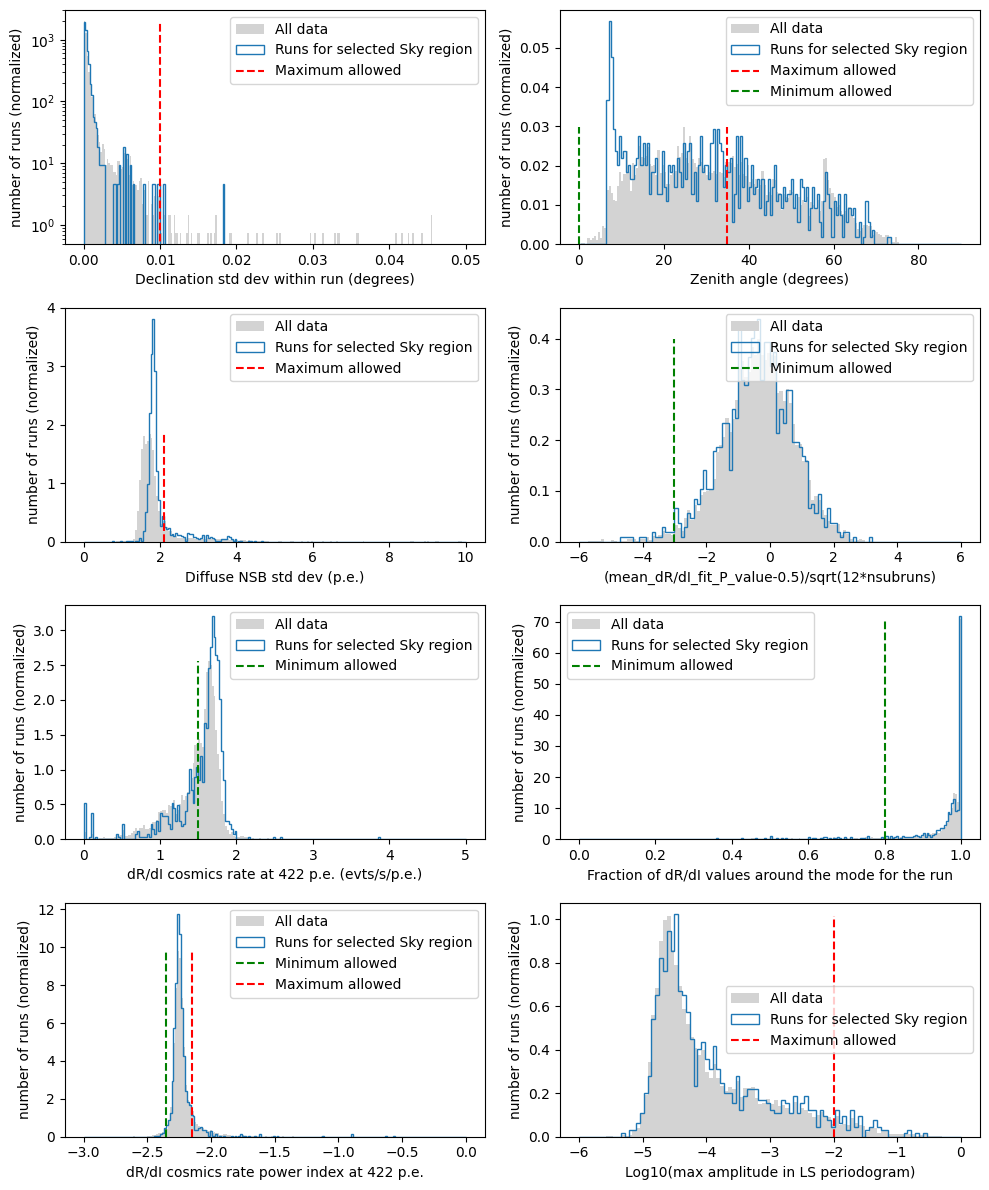

In [270]:
fig = plt.figure(figsize=(10, 12))


fig.add_subplot(4, 2, 1)
# Pointing stability
cc, bb, _ = plt.hist(std_dec, bins=250, range=(0,0.05), label='All data',
                    log=True, color='lightgrey', density=True)
plt.hist(std_dec[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         log=True, density=True, histtype='step')

plt.plot([max_pointing_dec_std, max_pointing_dec_std], [0, cc.max()], '--', label='Maximum allowed', color='red')
plt.xlabel('Declination std dev within run (degrees)')
plt.ylabel('number of runs (normalized)')
plt.legend()


fig.add_subplot(4, 2, 2)
cc, bb, _ = plt.hist(np.rad2deg(np.arccos(mean_coszd)), bins=180, range=(0,90), label='All data',
                     color='lightgrey', density=True)

plt.hist(np.rad2deg(np.arccos(mean_coszd))[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         density=True, histtype='step')

plt.plot([max_zenith.to_value(u.deg), max_zenith.to_value(u.deg)], 
         [0, cc.max()], '--', label='Maximum allowed', color='red')
plt.plot([min_zenith.to_value(u.deg), min_zenith.to_value(u.deg)], 
         [0, cc.max()], '--', label='Minimum allowed', color='green')

plt.xlabel('Zenith angle (degrees)')
plt.ylabel('number of runs (normalized)')
plt.legend()


fig.add_subplot(4, 2, 3)
cc, bb, _ = plt.hist(mean_diffuse_nsb_std, bins=200, range=(0,10), label='All data',
                     color='lightgrey', density=True)

plt.hist(mean_diffuse_nsb_std[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         density=True, histtype='step')

plt.plot([max_diffuse_nsb_std, max_diffuse_nsb_std], 
         [0, cc.max()], '--', label='Maximum allowed', color='red')
plt.xlabel('Diffuse NSB std dev (p.e.)')
plt.ylabel('number of runs (normalized)')
plt.legend()

fig.add_subplot(4, 2, 4)
cc, bb, _ = plt.hist((mean_fit_p_value-0.5)*(12*nsubruns)**0.5, 
                     bins=120, range=(-6,6), label='All data',
                     color='lightgrey', density=True)
plt.hist(((mean_fit_p_value-0.5)*(12*nsubruns)**0.5)[interleaved_ok_selection & skyregion_selection], 
         bins=bb, label='Runs for selected Sky region',
         density=True, histtype='step')
plt.plot([min_mean_fit_p, min_mean_fit_p], 
         [0, cc.max()], '--', label='Minimum allowed', color='green')
plt.xlabel('(mean_dR/dI_fit_P_value-0.5)/sqrt(12*nsubruns)')
plt.ylabel('number of runs (normalized)')
plt.legend()


fig.add_subplot(4, 2, 5)
cc, bb, _ = plt.hist(mean_R422, bins=200, range=(0,5), label='All data',
                     color='lightgrey', density=True)

plt.hist(mean_R422[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         density=True, histtype='step')

plt.plot([min_drdi_at_422pe, min_drdi_at_422pe], 
         [0, cc.max()], '--', label='Minimum allowed', color='green')
plt.xlabel('dR/dI cosmics rate at 422 p.e. (evts/s/p.e.)')
plt.ylabel('number of runs (normalized)')
plt.legend()


fig.add_subplot(4, 2, 6)
cc, bb, _ = plt.hist(fraction_around_mode_R422, bins=200, range=(0,1), 
                     label='All data', color='lightgrey', density=True)
plt.hist(fraction_around_mode_R422[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region', density=True, histtype='step')

plt.plot([min_fraction_around_mode, min_fraction_around_mode],
         [0, cc.max()], '--', label='Minimum allowed', color='green')
plt.xlabel('Fraction of dR/dI values around the mode for the run')
plt.ylabel('number of runs (normalized)')
plt.legend()



fig.add_subplot(4, 2, 7)
cc, bb, _ = plt.hist(mean_index, bins=200, range=(-3,0), label='All data',
                     color='lightgrey', density=True)

plt.hist(mean_index[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         density=True, histtype='step')

plt.plot([min_drdi_index, min_drdi_index], 
         [0, cc.max()], '--', label='Minimum allowed', color='green')
plt.plot([max_drdi_index, max_drdi_index], 
         [0, cc.max()], '--', label='Maximum allowed', color='red')
plt.xlabel('dR/dI cosmics rate power index at 422 p.e.')
plt.ylabel('number of runs (normalized)')
plt.legend()


fig.add_subplot(4, 2, 8)
cc, bb, _ = plt.hist(np.log10(max_lsc), bins=100, range=(-6,0), label='All data',
                     color='lightgrey', density=True)
plt.hist(np.log10(max_lsc)[interleaved_ok_selection & skyregion_selection], bins=bb,
         label='Runs for selected Sky region',
         density=True, histtype='step')
plt.plot([np.log10(max_LS_periodogram_maxamplitude), 
          np.log10(max_LS_periodogram_maxamplitude)], 
         [0, cc.max()], '--', label='Maximum allowed', color='red')
plt.xlabel('Log10(max amplitude in LS periodogram)')
plt.ylabel('number of runs (normalized)')
plt.legend()

print()
print('The dR/dI spectrum parameters below are corrected (for each subrun) to their ZD=0 equivalent')

plt.tight_layout()
plt.show()

## Print some runselection statistics

In [271]:
print('\nNumber of runs (% is w.r.t. those in Sky region & zenith range):\n')
starting_nruns = (date_selection & skyregion_selection).sum()
print('    In the requested Sky region and range of dates:\t\t', starting_nruns)

nruns_within_zdrange = (date_selection & skyregion_selection & zd_selection).sum()
print('  + zenith in requested range:\t\t\t\t', nruns_within_zdrange)

nruns_nsb_ok = (date_selection & skyregion_selection & zd_selection &
                nsb_selection).sum()
print('  + NSB in requested range:\t\t\t\t', nruns_nsb_ok,
      f'({nruns_nsb_ok/nruns_within_zdrange*100:.1f}%)')


nruns_interleaved_ok = (date_selection & skyregion_selection & zd_selection &
                        nsb_selection & interleaved_ok_selection).sum()
print('  + FF and pedestal interleaved events are present:\t', nruns_interleaved_ok,
      f'({nruns_interleaved_ok/nruns_within_zdrange*100:.1f}%)')

nruns_stable_pointing = (date_selection & skyregion_selection & zd_selection &
                         nsb_selection & interleaved_ok_selection & 
                         pointing_stability_selection).sum()
print('  + Stable pointing:\t\t\t\t\t', nruns_stable_pointing,
      f'({nruns_stable_pointing/nruns_within_zdrange*100:.1f}%)')

nruns_fit_p_value_ok = (date_selection & skyregion_selection & zd_selection &
                        nsb_selection & interleaved_ok_selection & 
                        pointing_stability_selection &
                        p_value_selection).sum()
print('  + dR/dI fit P-value ok:\t\t\t\t', nruns_fit_p_value_ok,
      f'({nruns_fit_p_value_ok/nruns_within_zdrange*100:.1f}%)')

nruns_LS_periodogram_ok = (date_selection & skyregion_selection & zd_selection &
                           nsb_selection & interleaved_ok_selection & 
                           pointing_stability_selection &
                           p_value_selection & LS_periodogram_selection).sum()
print('  + dR/dI LS periodogram ok:\t\t\t\t', nruns_LS_periodogram_ok,
      f'({nruns_LS_periodogram_ok/nruns_within_zdrange*100:.1f}%)')

nruns_drdi_index_ok = (date_selection & skyregion_selection & zd_selection &
                       nsb_selection & interleaved_ok_selection & 
                       pointing_stability_selection & 
                       p_value_selection & LS_periodogram_selection &
                       drdi_index_selection).sum()
print('  + dR/dI index ok:\t\t\t\t\t', nruns_drdi_index_ok,
      f'({nruns_drdi_index_ok/nruns_within_zdrange*100:.1f}%)')

nruns_drdi_rate_ok = (date_selection & skyregion_selection & zd_selection &
                      nsb_selection & interleaved_ok_selection & 
                      pointing_stability_selection & 
                      p_value_selection & LS_periodogram_selection &
                      drdi_index_selection & drdi_rate_selection).sum()

print('  + dR/dI rate ok:\t\t\t\t\t', nruns_drdi_rate_ok,
      f'({nruns_drdi_rate_ok/nruns_within_zdrange*100:.1f}%)')

print('\nNote: about 64% of *dark-night* observations within ZD<50 deg fulfill all quality cuts')


Number of runs (% is w.r.t. those in Sky region & zenith range):

    In the requested Sky region and range of dates:		 416
  + zenith in requested range:				 213
  + NSB in requested range:				 188 (88.3%)
  + FF and pedestal interleaved events are present:	 184 (86.4%)
  + Stable pointing:					 179 (84.0%)
  + dR/dI fit P-value ok:				 175 (82.2%)
  + dR/dI LS periodogram ok:				 171 (80.3%)
  + dR/dI index ok:					 168 (78.9%)
  + dR/dI rate ok:					 143 (67.1%)

Note: about 64% of *dark-night* observations within ZD<50 deg fulfill all quality cuts


In [272]:
# All selections but the dR/dI rate cuts:
mask_no_drdi_rate_cut = (date_selection & 
                         skyregion_selection & 
                         zd_selection & 
                         nsb_selection &
                         interleaved_ok_selection & 
                         pointing_stability_selection & 
                         p_value_selection &
                         LS_periodogram_selection &
                         drdi_index_selection)

In [273]:
mask = mask_no_drdi_rate_cut & drdi_rate_selection

good_runs = runlist[mask]

print('Selected:', mask.sum(), 'of', runlist.size, 'runs')

obs_hours = runsummary['elapsed_time'][mask].sum()/3600

print(f'Total observation time: {obs_hours:.2f} h')

Selected: 143 of 6952 runs
Total observation time: 43.57 h


## We show below the distribution of the "intensity threshold", defined as the position of the rising edge (50% of peak) of the cosmic ray intensity spectrum

We do not use this by default in the slection, because data may be perfectly healthy even when they have a higher threshold than usual. The cut in intensity applied in the analyis of low-threshold (<40) data is >50 p.e. 
The cut should be higher (to prevent biases in flux calculations) for data with higher threshold.

##

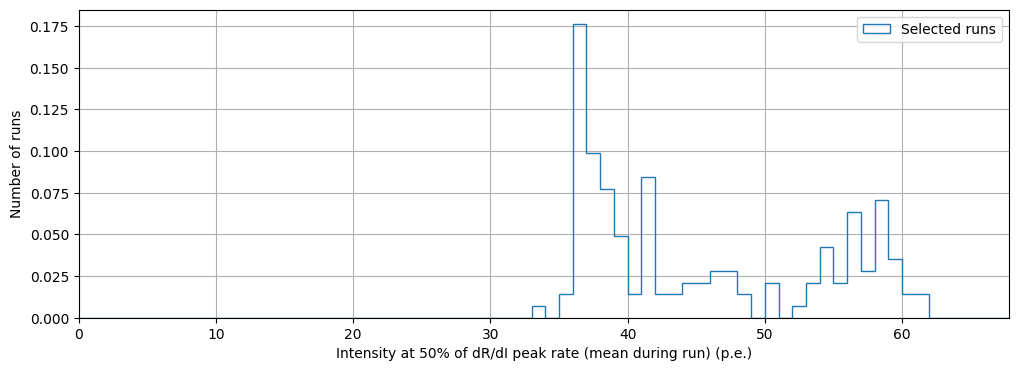

In [274]:
plt.figure(figsize=(12, 4))
plt.hist(mean_intensity_threshold[mask], 
         bins=200, range=(0,200), label='Selected runs', # log=True, 
         density=True, histtype='step')
plt.xlim(0, np.max(mean_intensity_threshold[mask])*1.1)
plt.grid()
plt.xlabel('Intensity at 50% of dR/dI peak rate (mean during run) (p.e.)')
plt.ylabel('Number of runs')
plt.legend()
plt.show()

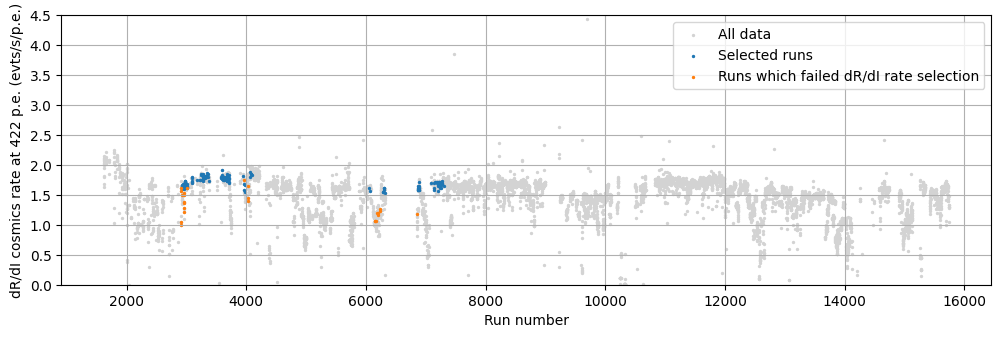

In [275]:
plt.figure(figsize=(12, 3.5))
plt.scatter(runlist, mean_R422, s=2, color='lightgrey', label='All data')
plt.scatter(runlist[mask], mean_R422[mask], s=2, label='Selected runs')

plt.scatter(runlist[(~mask) & mask_no_drdi_rate_cut], mean_R422[(~mask) & mask_no_drdi_rate_cut], s=2, 
            label='Runs which failed dR/dI rate selection')

plt.xlabel('Run number')
plt.ylabel('dR/dI cosmics rate at 422 p.e. (evts/s/p.e.)')
plt.ylim(0, 4.5)
plt.legend()
plt.grid()
plt.show()

2929 max_lsc: 3.78e-04
     std R422: 0.09


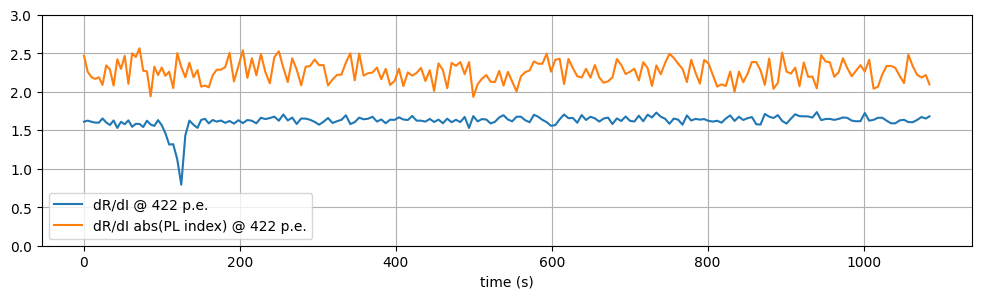


2950 max_lsc: 9.93e-05
     std R422: 0.04


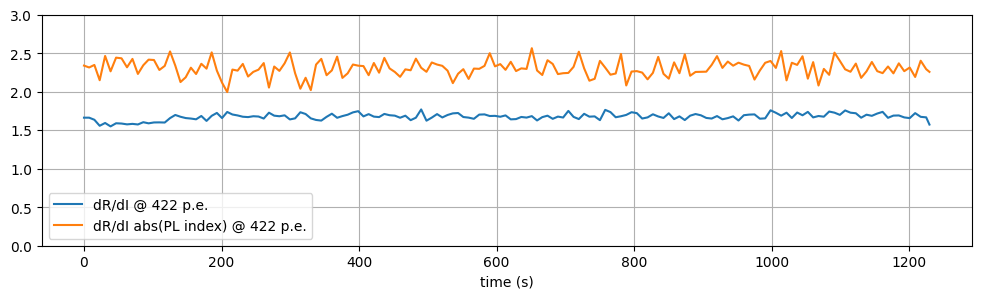


2971 max_lsc: 2.62e-05
     std R422: 0.03


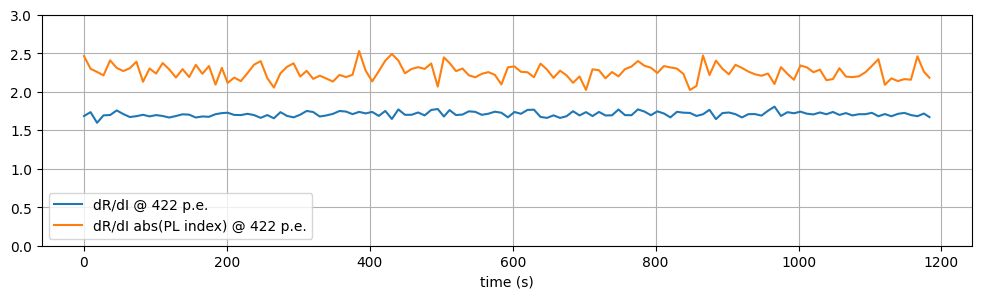


2988 max_lsc: 4.37e-05
     std R422: 0.04


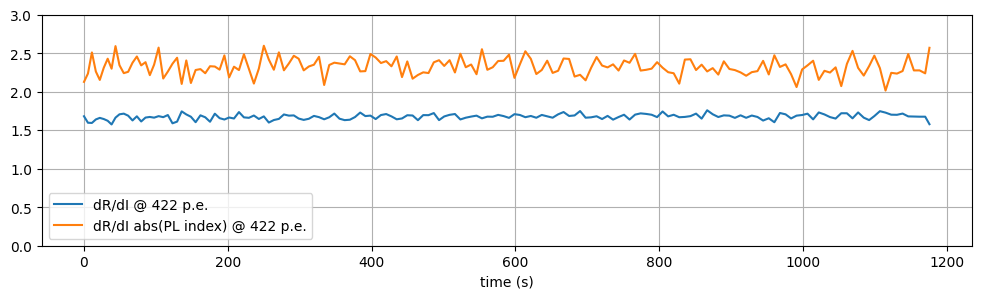


3007 max_lsc: 1.21e-03
     std R422: 0.13


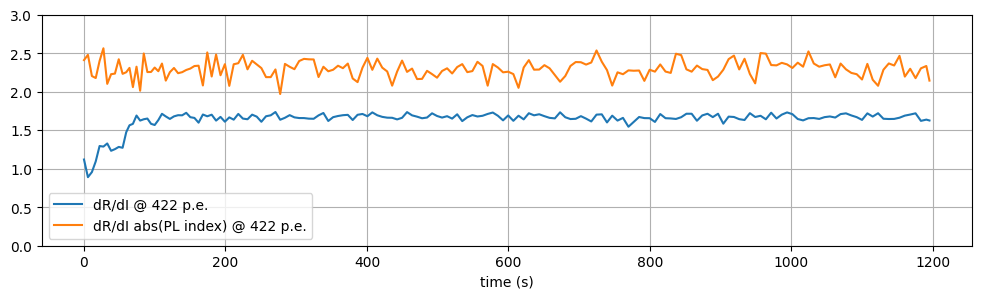


3097 max_lsc: 5.91e-05
     std R422: 0.03


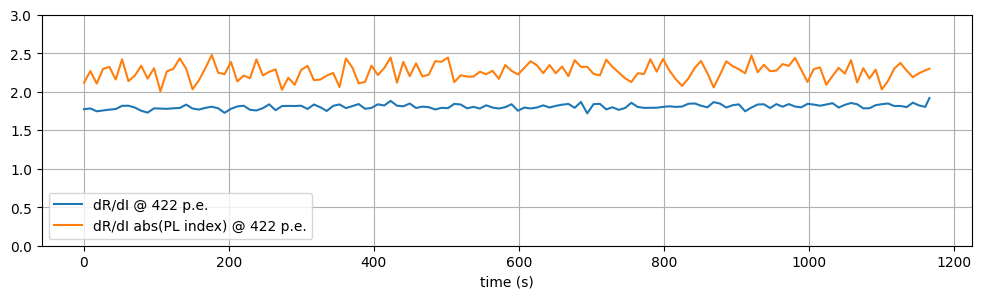


3270 max_lsc: 2.40e-05
     std R422: 0.03


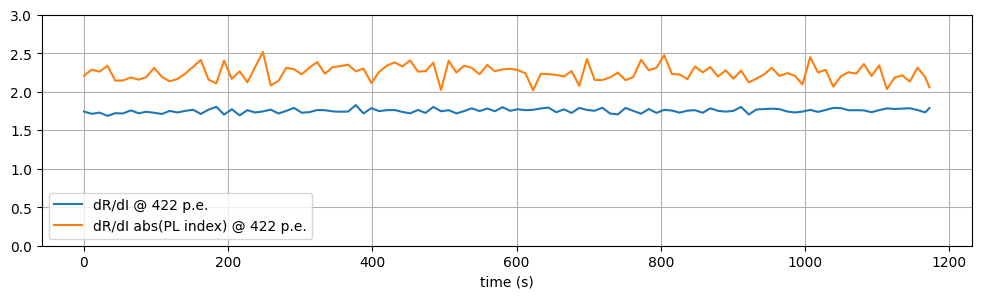


3277 max_lsc: 3.20e-05
     std R422: 0.02


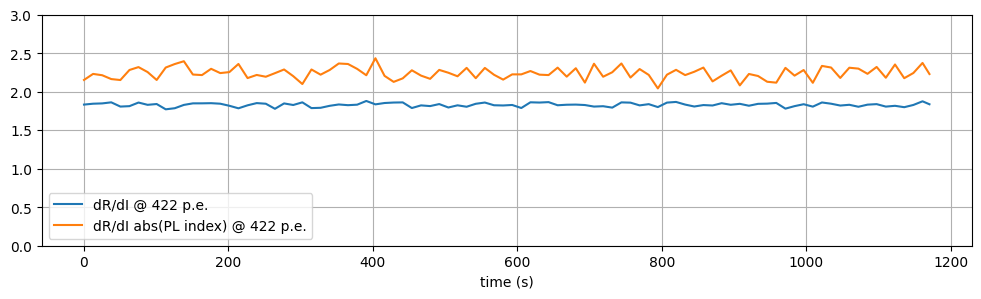


3328 max_lsc: 1.87e-05
     std R422: 0.02


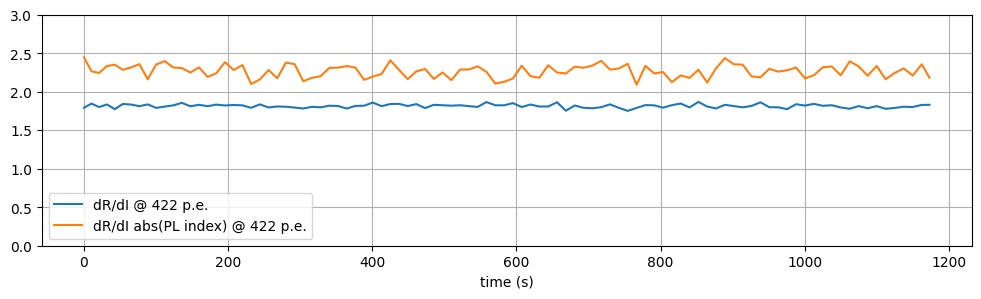


3373 max_lsc: 2.76e-05
     std R422: 0.03


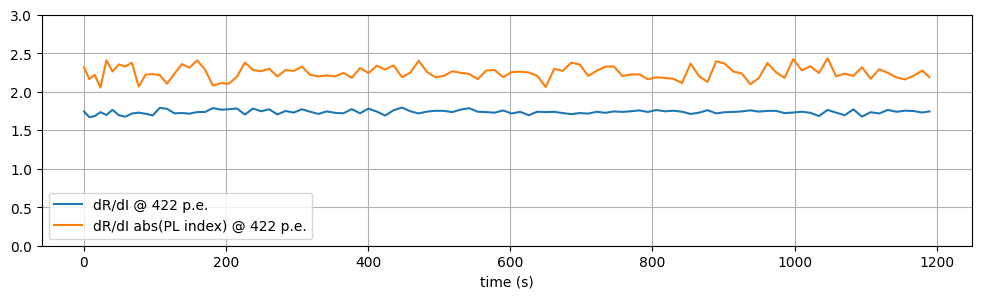


3616 max_lsc: 1.96e-04
     std R422: 0.07


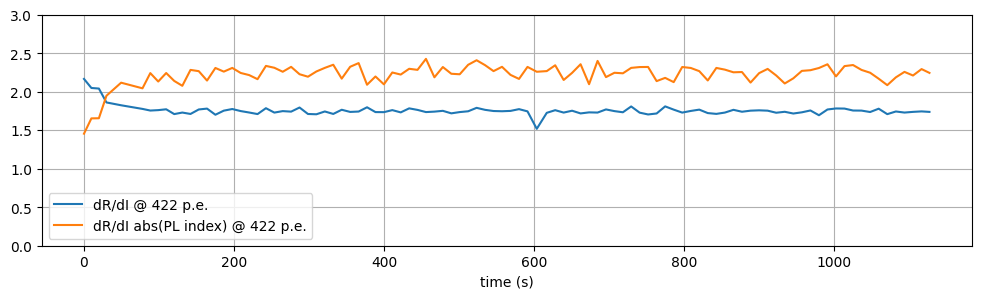


3672 max_lsc: 1.02e-05
     std R422: 0.02


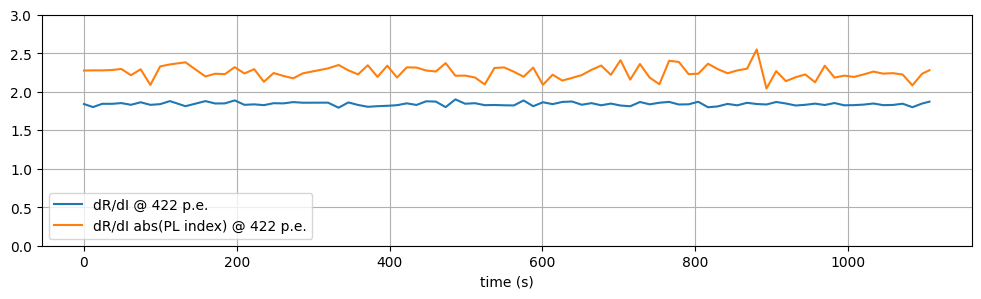


3679 max_lsc: 2.81e-05
     std R422: 0.02


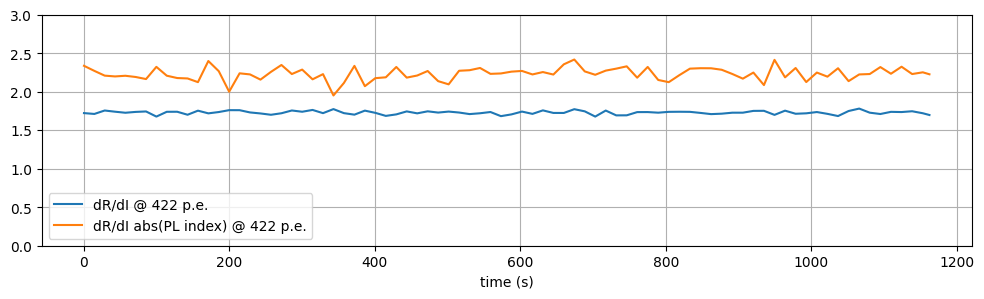


3955 max_lsc: 1.22e-03
     std R422: 0.13


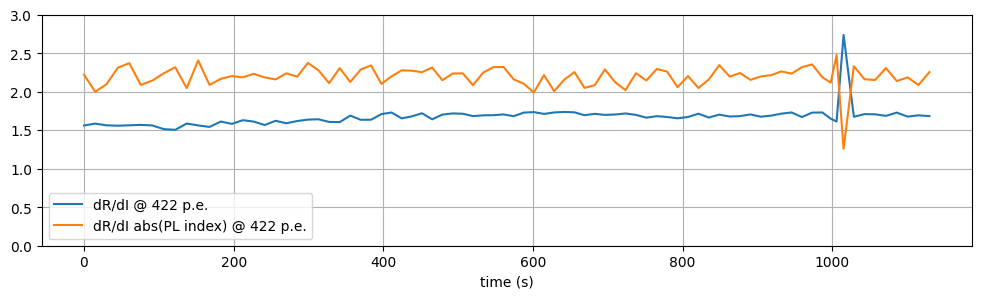


4087 max_lsc: 1.18e-05
     std R422: 0.02


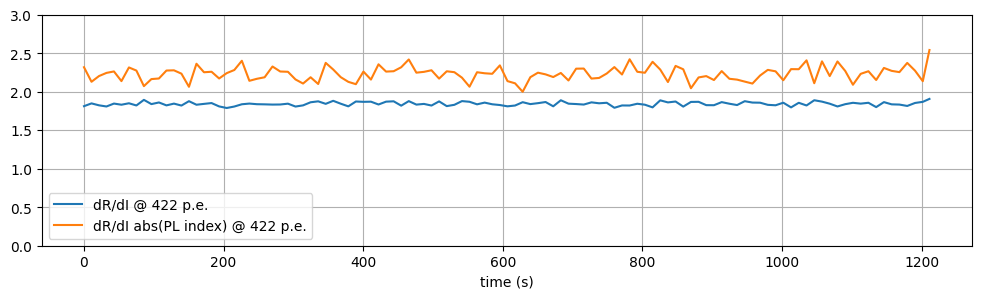


6303 max_lsc: 6.61e-04
     std R422: 0.22


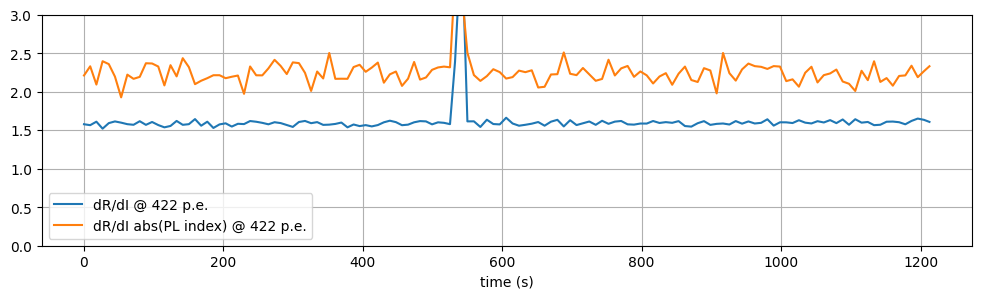


6875 max_lsc: 2.90e-05
     std R422: 0.03


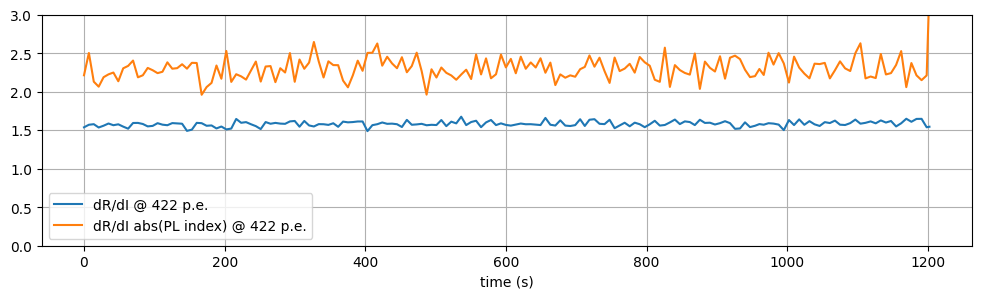


7133 max_lsc: 5.82e-05
     std R422: 0.04


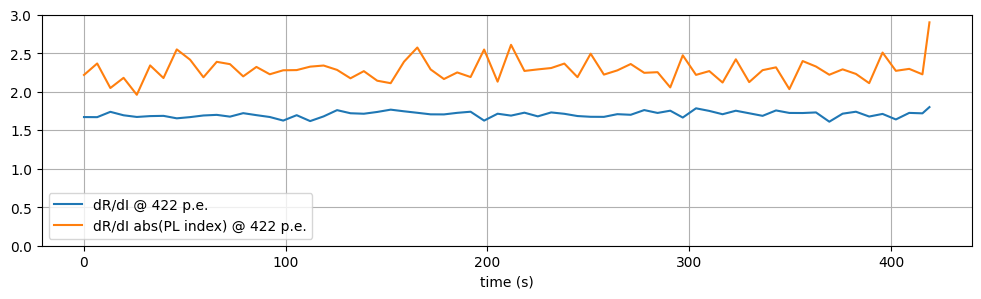


7198 max_lsc: 1.30e-04
     std R422: 0.07


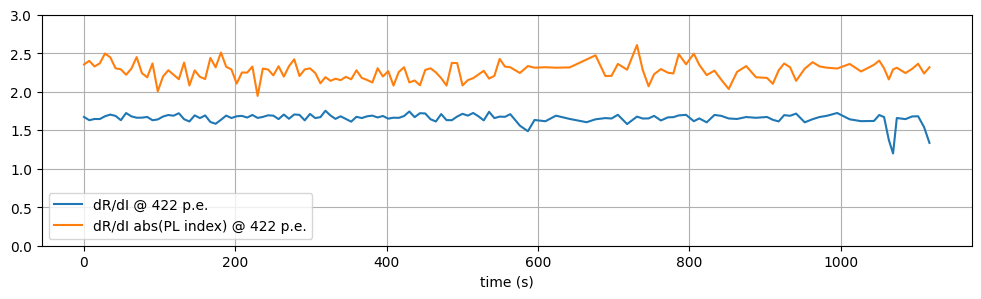


7233 max_lsc: 1.88e-05
     std R422: 0.03


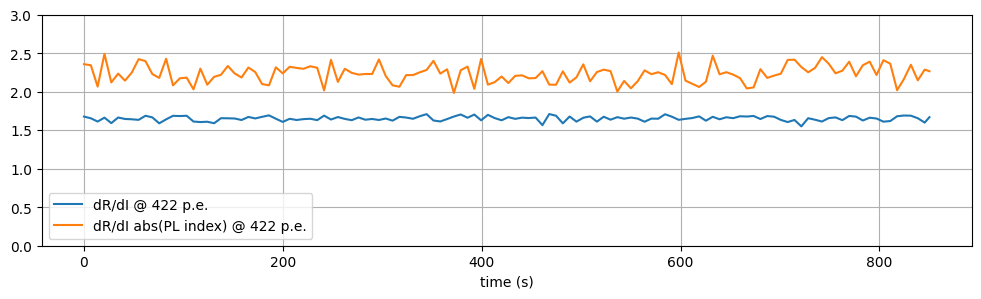


7276 max_lsc: 7.47e-05
     std R422: 0.03


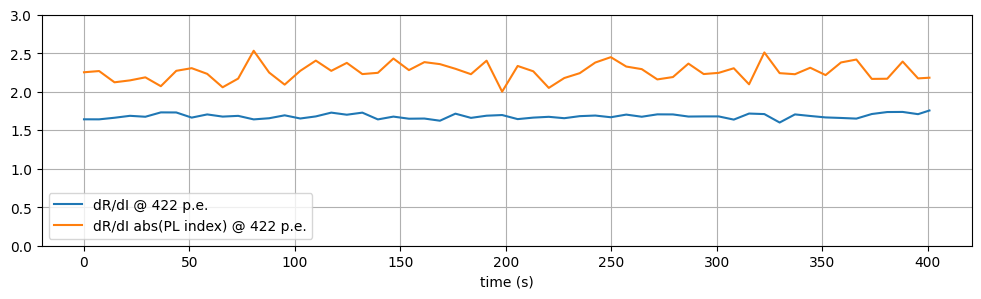

In [276]:
# Show for (at most) 20 of the selected spectra the evolution of dR/dI through the run:

for jj in runlist[mask][::(mask.sum()//20)]:
    plt.figure(figsize=(12, 3))
    print(jj, f'max_lsc: {max_lsc[runlist==jj][0]:.2e}')
    print('    ', f'std R422: {std_R422[runlist==jj][0]:.2f}')
    xt = cis['time'][cis['runnumber']==jj] - cis['time'][cis['runnumber']==jj].min()
    plt.plot(xt,
             cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj], label='dR/dI @ 422 p.e.')

    plt.plot(xt,
             -cis['ZD_corrected_cosmics_spectral_index'][cis['runnumber']==jj], label='dR/dI abs(PL index) @ 422 p.e.')

#     plt.scatter(xt,
#                 cis['intensity_spectrum_fit_p_value'][cis['runnumber']==jj], 
#                 label='Fit P-value', color='tab:orange')
    plt.grid()

    plt.ylim(0, 3)
    #plt.xlim(0,1200)
    plt.xlabel('time (s)')
    # plt.ylabel('dR/dI at 422 p.e.')
    plt.legend()
    plt.show()
    print()


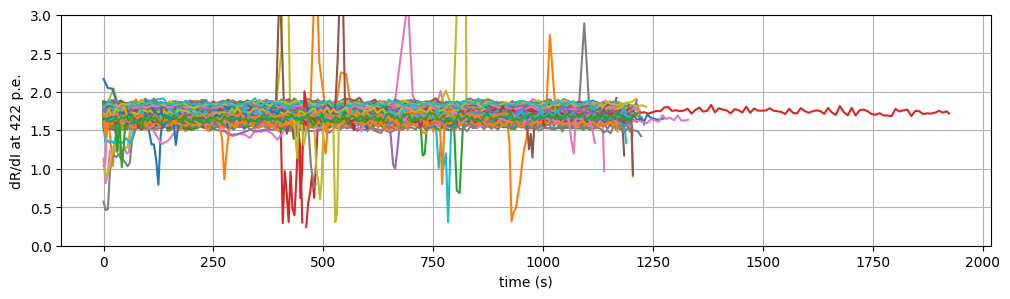

Total number of subruns in selected sample: 16874
Do not panic about the ugly-looking spikes, they are rare:
21 subruns (0.124%)  have dR/dI @ 422 larger than 2
136 subruns (0.806%)  have dR/dI @ 422 smaller than 1.4


In [277]:
plt.figure(figsize=(12, 3))

# count number of dR/dI-wise "anomalous" subruns in selected sample:
drdi_high = 2
too_high = 0
drdi_low = 1.4
too_low = 0
total_nsubruns = 0

for jj in runlist[mask]:
    xt = cis['time'][cis['runnumber']==jj] - cis['time'][cis['runnumber']==jj].min()
    plt.plot(xt,
             cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj])
    too_high += (cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj] > drdi_high).sum()
    too_low  += (cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj] < drdi_low).sum()
    total_nsubruns += (cis['runnumber']==jj).sum()

plt.ylim(0, 3)
#plt.xlim(0,1200)
plt.xlabel('time (s)')
plt.ylabel('dR/dI at 422 p.e.')
plt.grid()
plt.show()

print('Total number of subruns in selected sample:', total_nsubruns)
print('Do not panic about the ugly-looking spikes, they are rare:')
print(too_high, f'subruns ({100*too_high/total_nsubruns:.3f}%)',' have dR/dI @ 422 larger than', drdi_high)
print(too_low,  f'subruns ({100*too_low/total_nsubruns:.3f}%)', ' have dR/dI @ 422 smaller than', drdi_low)


In [278]:
subrun_mask = np.array([True if x in good_runs else False for x in cis['runnumber']])

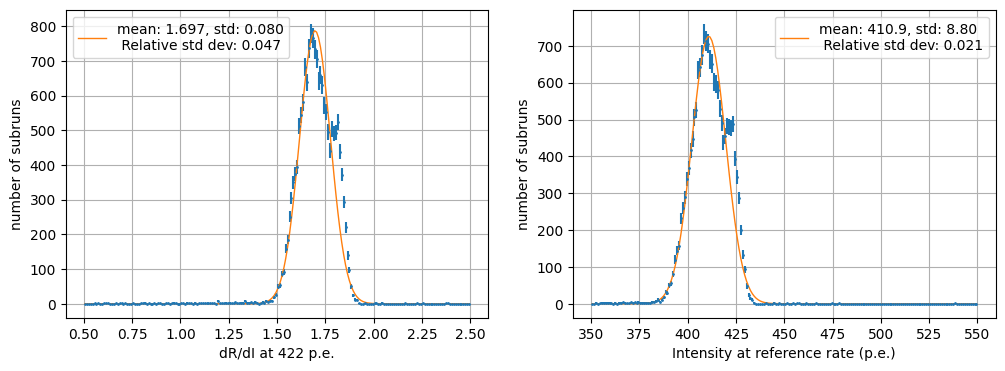

In [279]:
from scipy.stats.distributions import norm
from scipy.optimize import curve_fit
def gaus(x, a, b, c):
    return a*norm.pdf(x, b, c)

fig = plt.figure(figsize=(12,4))
fig.add_subplot(1, 2, 1)
cc, bb = np.histogram(cis['ZD_corrected_cosmics_rate_at_422_pe'][subrun_mask], bins=200, range=(0.5, 2.5))
xx = 0.5*(bb[1:]+bb[:-1])
plt.errorbar(xx, cc, yerr=cc**0.5, fmt='o', markersize=1)

# NOTE: you may have to play with starting parameters if fit does not converge:
params, _ = curve_fit(gaus, xx[cc>0], cc[cc>0], sigma=cc[cc>0]**0.5, 
                      p0=[100, 1.7, 0.1])
plt.plot(xx, gaus(xx, params[0], params[1], params[2]), linewidth=1,
         label=f'mean: {params[1]:.3f}, std: {params[2]:.3f}\n Relative std dev: {params[2]/params[1]:.3f}')

plt.legend()
plt.xlabel('dR/dI at 422 p.e.')
plt.ylabel('number of subruns')
plt.grid()

fig.add_subplot(1, 2, 2)
cc, bb = np.histogram(cis['intensity_at_reference_rate'][subrun_mask], bins=200, range=(350, 550))
xx = 0.5*(bb[1:]+bb[:-1])
plt.errorbar(xx, cc, yerr=cc**0.5, fmt='o', markersize=1)

# NOTE: you may have to play with starting parameters if fit does not converge:
params, _ = curve_fit(gaus, xx[cc>0], cc[cc>0], sigma=cc[cc>0]**0.5, 
                      p0=[100, 400, 2])

plt.plot(xx, gaus(xx, params[0], params[1], params[2]), linewidth=1,
         label=f'mean: {params[1]:.1f}, std: {params[2]:.2f}\n Relative std dev: {params[2]/params[1]:.3f}')

plt.legend()
plt.xlabel('Intensity at reference rate (p.e.)')
plt.ylabel('number of subruns')
plt.grid()


plt.show()

If we interpret variations in dR/dI @ 422 p.e. as variations in atmospheric transmissivity (folded with whatever other factors determining the total light yield, e.g. the telescope throughput), the relative std dev in the fit of the right panel gives us an idea of the stability of the light yield throughout the sample.

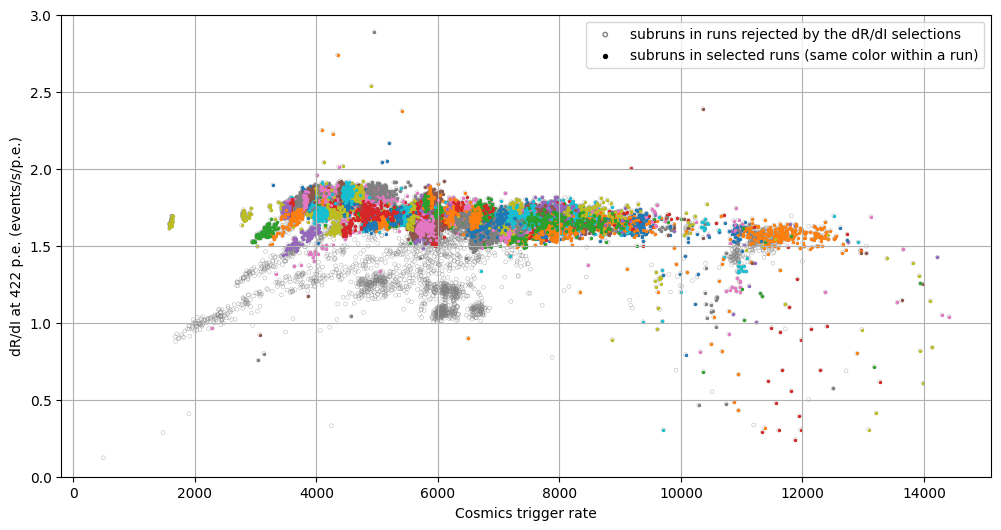

In [280]:
plt.figure(figsize=(12,6))


#                label='subruns in selected runs (same color within a run)'

plt.scatter([], [], facecolors='none', edgecolors='grey', 
            label='subruns in runs rejected by the dR/dI selections', s=10)
plt.scatter([], [], color='black', 
            label='subruns in selected runs (same color within a run)', s=8)

for jj in runlist[mask_no_drdi_rate_cut]:
    plt.scatter(cis['cosmics_rate'][cis['runnumber']==jj],
                cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj], s=8, 
                facecolors='none', edgecolors='grey', linewidth=0.2)

for jj in runlist[mask]:
    plt.scatter(cis['cosmics_rate'][cis['runnumber']==jj],
                cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj], s=2)
plt.ylim(0, 3)
plt.legend()
plt.xlabel('Cosmics trigger rate')
plt.ylabel('dR/dI at 422 p.e. (events/s/p.e.)')
plt.grid()
plt.show()

In the plot above:
* Subruns with large cosmics trigger rate and lof dR/dI values are usually those affected by car flashes or other external sources of light
* Low trigger rate andlow value of dR/dI likely indicate poor atmospheric transmissivity.

Run 10882 Date: [20221119]


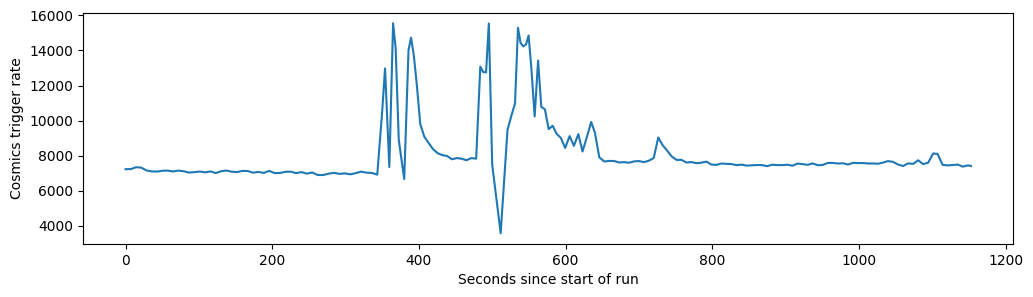

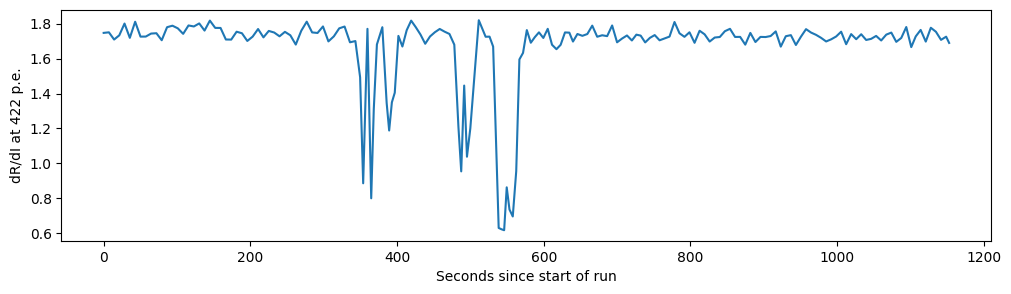

In [281]:
# Plot a specific suspicious run, to check e.g. if there was a spike in rates, which explains
# a too high value of the cosmics rate dR/dI @ 422 p.e.
#
# Run number:
rr = 10882 
# 10882 example of many rate spikes
# Comment in runbook: 
# "busy spike. Operator Specialist cannot reach the toilet without flashing the camera."

print('Run', rr, 'Date:', rundate[runlist==rr])
xt = cis['time'][cis['runnumber']==rr] - cis['time'][cis['runnumber']==rr].min()

plt.figure(figsize=(12, 3))
plt.plot(xt, cis['cosmics_rate'][cis['runnumber']==rr])
plt.xlabel('Seconds since start of run')
plt.ylabel('Cosmics trigger rate')
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(xt, cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==rr])
plt.xlabel('Seconds since start of run')
plt.ylabel('dR/dI at 422 p.e.')
plt.show()

In [282]:
crab_paper_runs = np.array([2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
                            2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
                            2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
                            3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
                            3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
                            3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632,
                            3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707,
                            3708, 4067, 4068, 4086, 4087, 6045, 6073, 6304, 6872, 6873, 6874,
                            6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099, 7133, 7136, 7161,
                            7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253,
                            7254, 7255, 7256, 7274, 7275, 7276, 7277])

In [283]:
mask_dict = {"date_selection": date_selection,
             "skyregion_selection": skyregion_selection,
             "interleaved_ok_selection": interleaved_ok_selection,
             "pointing_stability_selection": pointing_stability_selection,
             "zd_selection": zd_selection,
             "nsb_selection": nsb_selection,
             "p_value_selection": p_value_selection,
             "LS_periodogram_selection": LS_periodogram_selection,
             "drdi_index_selection": drdi_index_selection,
             "drdi_rate_selection": drdi_rate_selection}

In [284]:
def test_run(run, mask_dict=mask_dict):
    for x in mask_dict:
        if mask_dict[x][runlist==run][0]:
            continue
        print(x, mask_dict[x][runlist==run])

In [285]:
# Example: which selection removed run 2914?
test_run(2914)

drdi_rate_selection [False]


In [286]:
# checklist = []
# for r in crab_paper_runs:
#     if r in good_runs:
#         continue
#     checklist.append(r)

## Check a few of the runs that were removed because of the dR/dI cuts

Note: if the only issue (aside from the occasional spike) in a data run is a low mean value of the dR/dI rate at 422 p.e., and/or unstable value (smaller than required fraction of subruns around the mode), then it may be a good candidate for re-analysis via correction of the pixel-wise light values

In [287]:
# Runs which fulfill all selections except the dR/dI rate selection
checklist = runlist[(~mask) & mask_no_drdi_rate_cut]

In [288]:
checklist

array([2913, 2914, 2916, 2917, 2925, 2952, 2953, 2954, 2955, 2956, 2957,
       3005, 3954, 4027, 4028, 4029, 6147, 6148, 6172, 6193, 6194, 6195,
       6241, 6242, 6853])

2913 max_lsc: 9.43e-03
drdi_rate_selection [False]


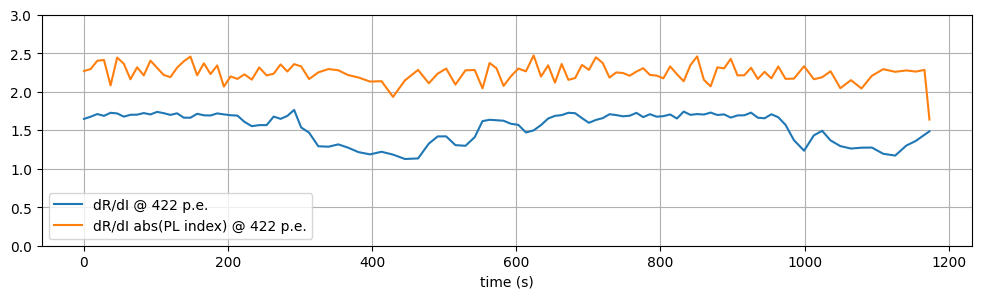


2914 max_lsc: 1.04e-03
drdi_rate_selection [False]


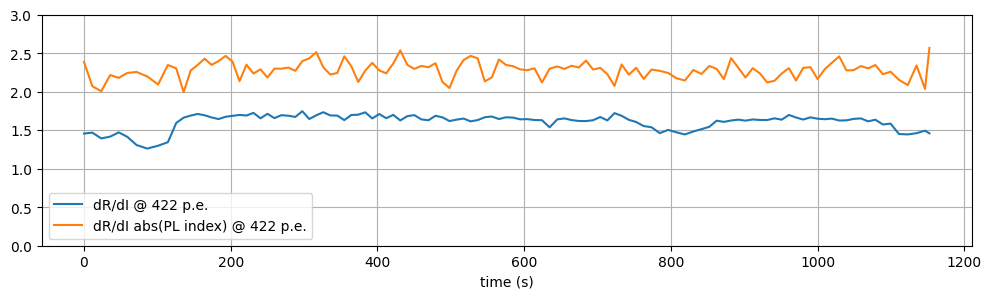


2916 max_lsc: 2.27e-03
drdi_rate_selection [False]


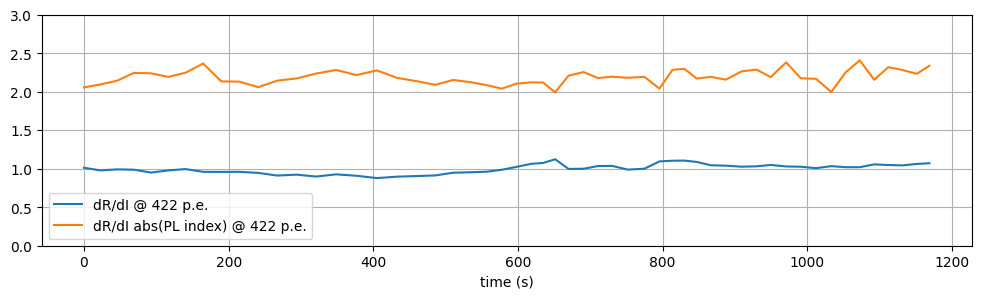


2917 max_lsc: 2.88e-03
drdi_rate_selection [False]


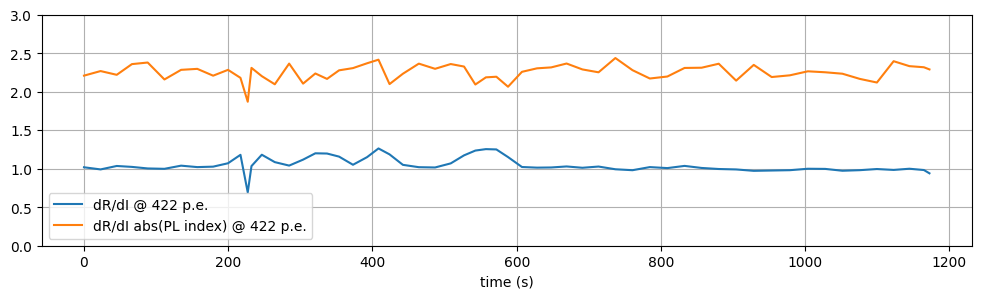


2925 max_lsc: 7.33e-04
drdi_rate_selection [False]


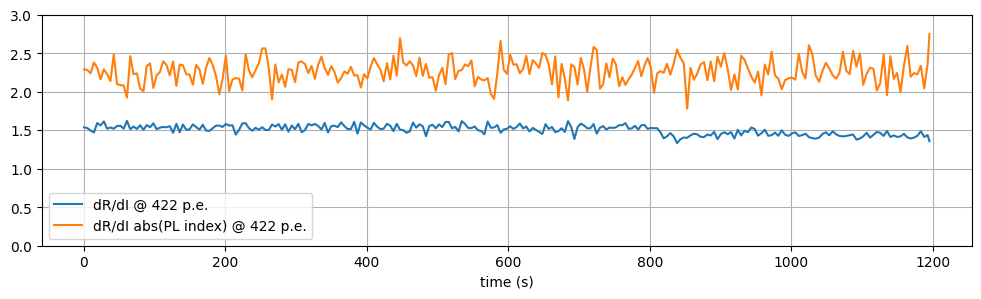


2952 max_lsc: 3.44e-03
drdi_rate_selection [False]


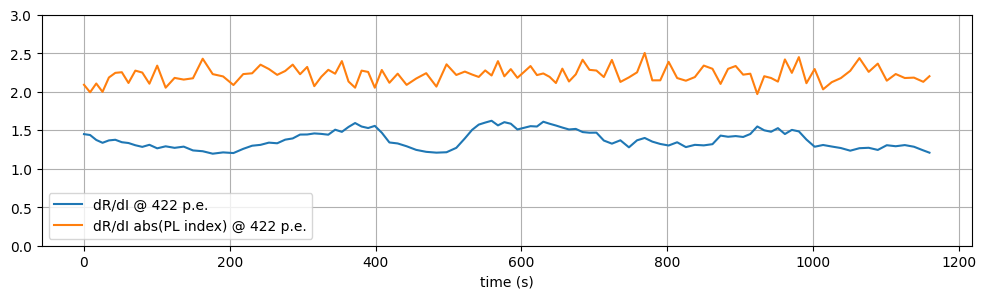


2953 max_lsc: 4.42e-03
drdi_rate_selection [False]


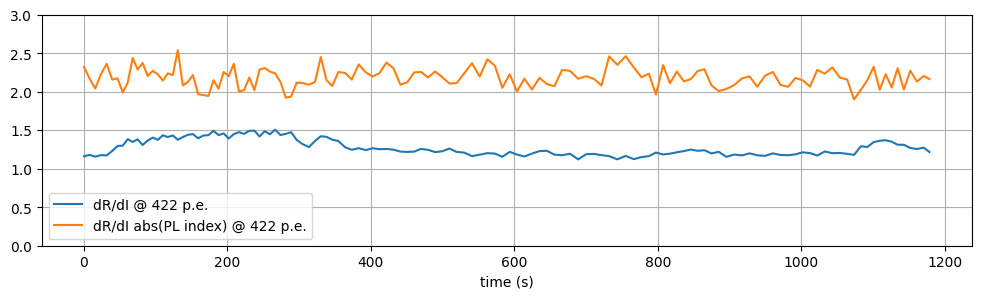


2954 max_lsc: 1.14e-03
drdi_rate_selection [False]


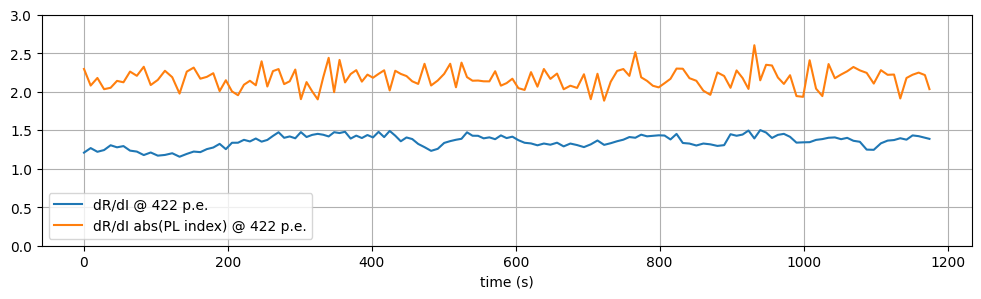


2955 max_lsc: 1.38e-03
drdi_rate_selection [False]


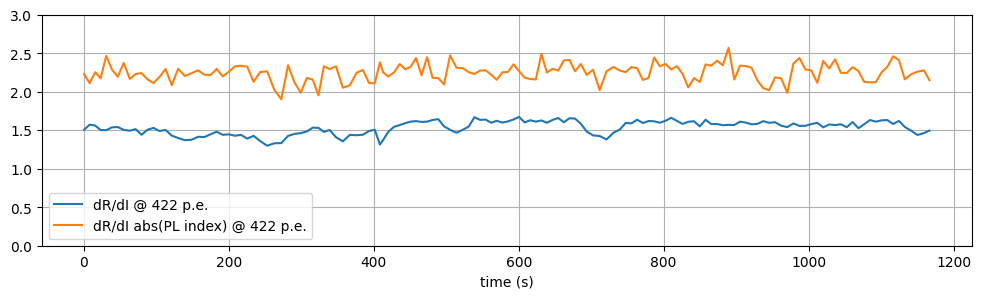


2956 max_lsc: 4.45e-04
drdi_rate_selection [False]


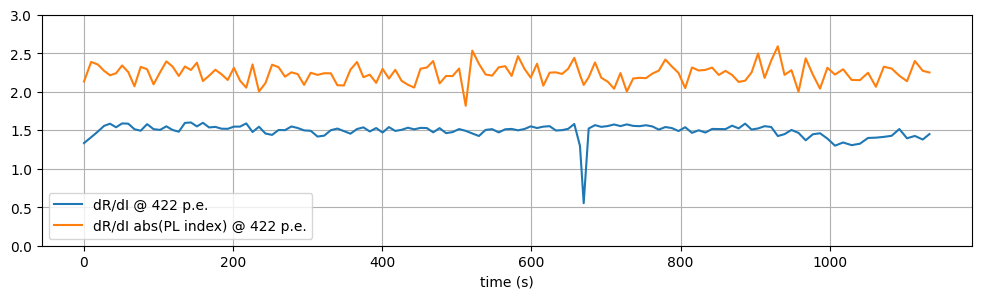


2957 max_lsc: 6.46e-03
drdi_rate_selection [False]


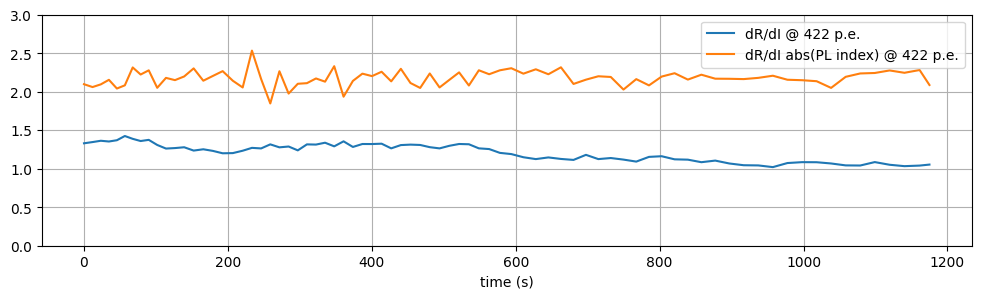


3005 max_lsc: 3.71e-03
drdi_rate_selection [False]


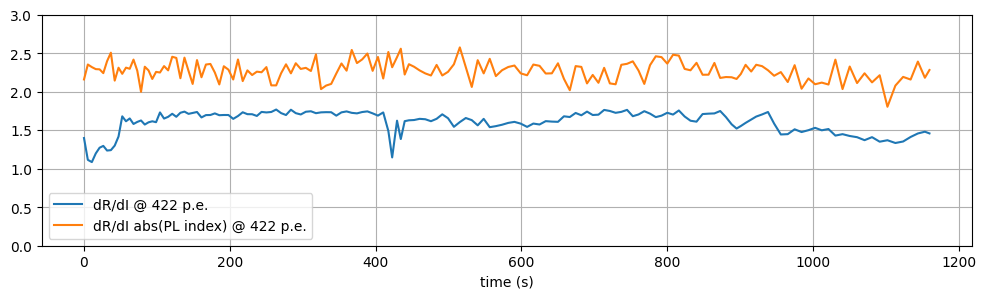


3954 max_lsc: 1.32e-03
drdi_rate_selection [False]


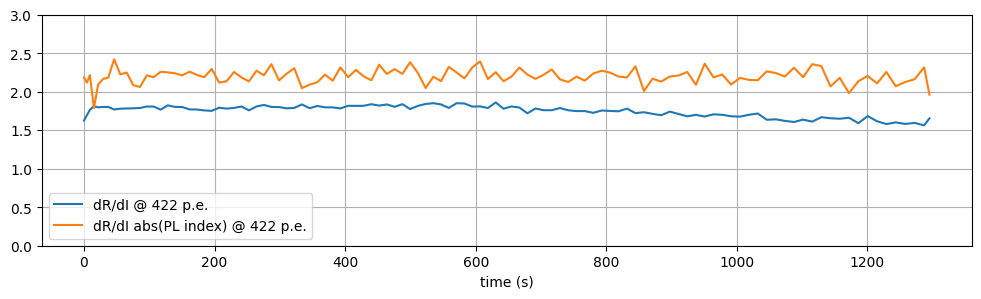


4027 max_lsc: 2.46e-03
drdi_rate_selection [False]


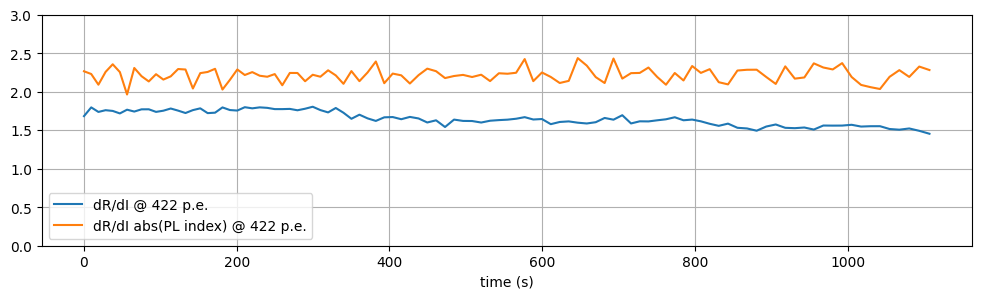


4028 max_lsc: 2.31e-03
drdi_rate_selection [False]


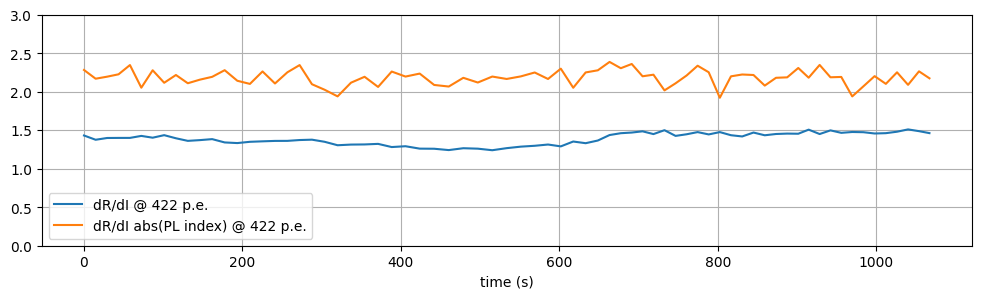


4029 max_lsc: 6.63e-03
drdi_rate_selection [False]


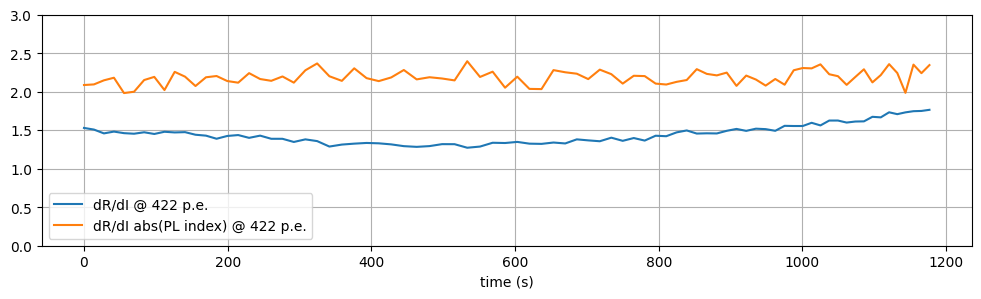


6147 max_lsc: 3.08e-04
drdi_rate_selection [False]


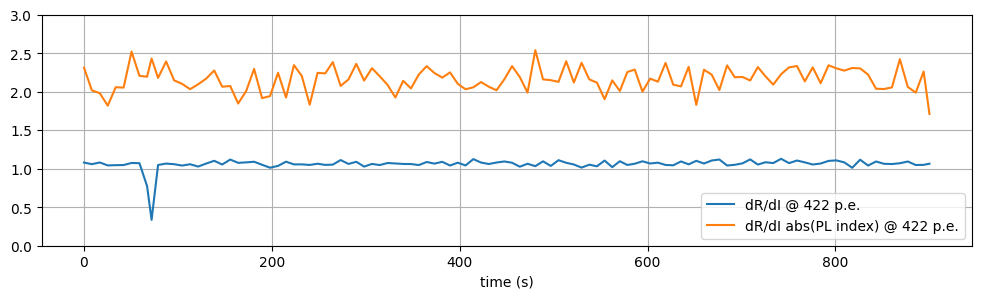


6148 max_lsc: 5.27e-04
drdi_rate_selection [False]


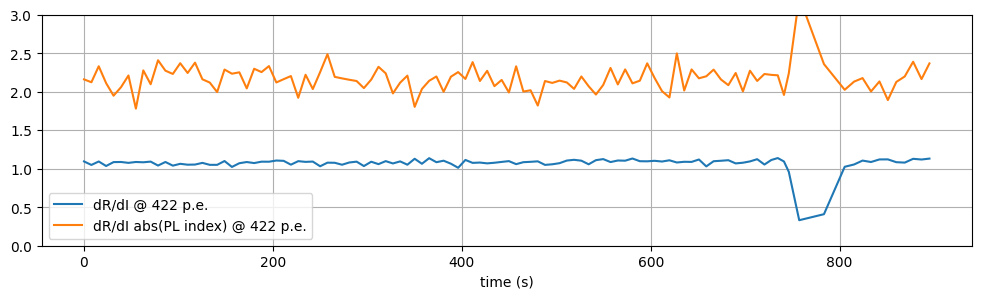


6172 max_lsc: 9.18e-05
drdi_rate_selection [False]


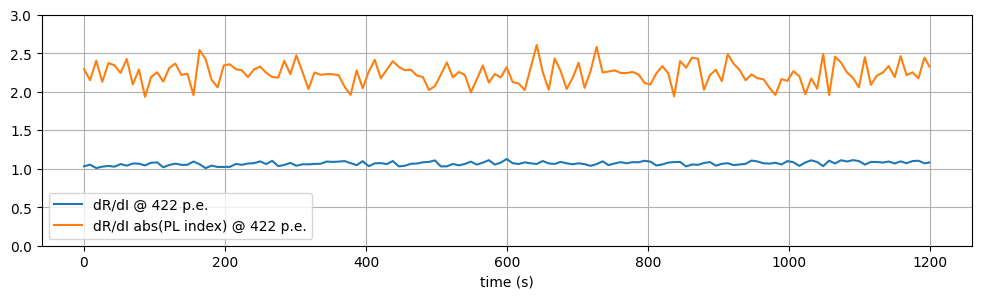


6193 max_lsc: 2.31e-05
drdi_rate_selection [False]


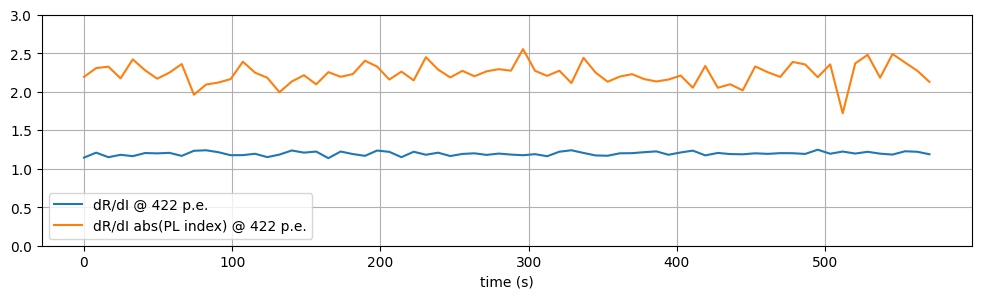


6194 max_lsc: 3.93e-05
drdi_rate_selection [False]


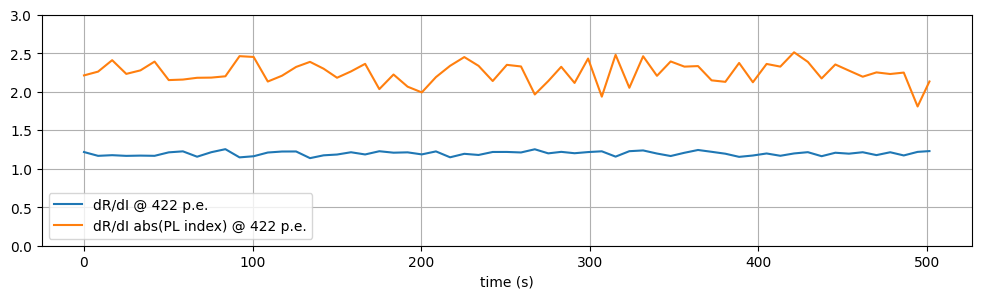


6195 max_lsc: 8.37e-03
drdi_rate_selection [False]


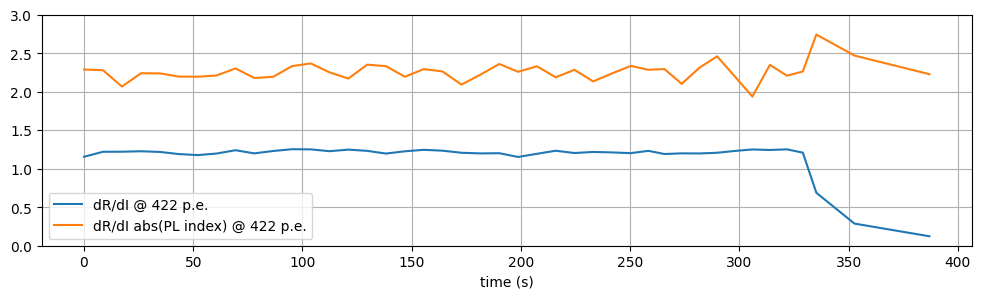


6241 max_lsc: 1.22e-04
drdi_rate_selection [False]


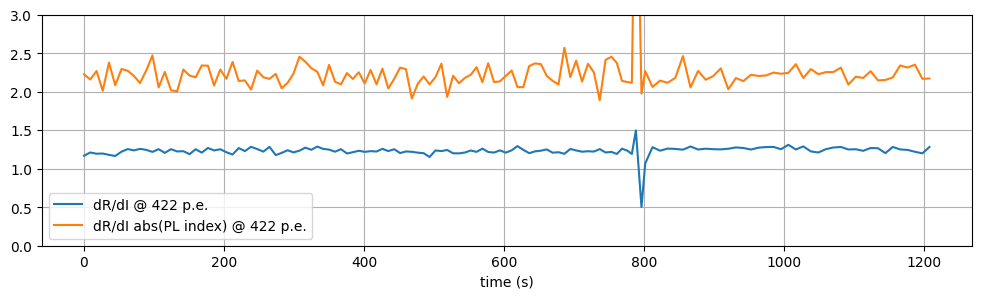


6242 max_lsc: 4.78e-05
drdi_rate_selection [False]


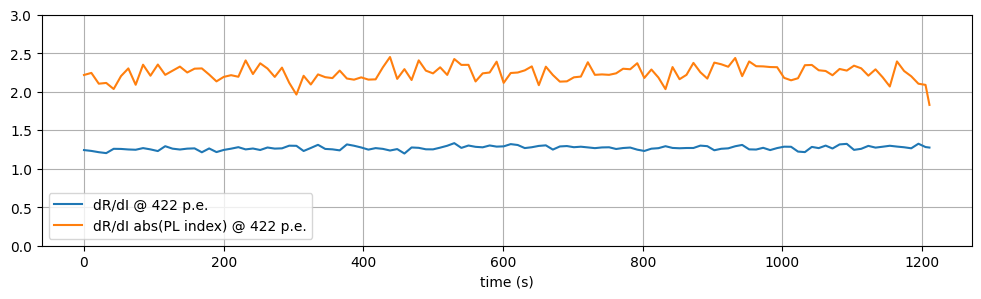


6853 max_lsc: 7.68e-03
drdi_rate_selection [False]


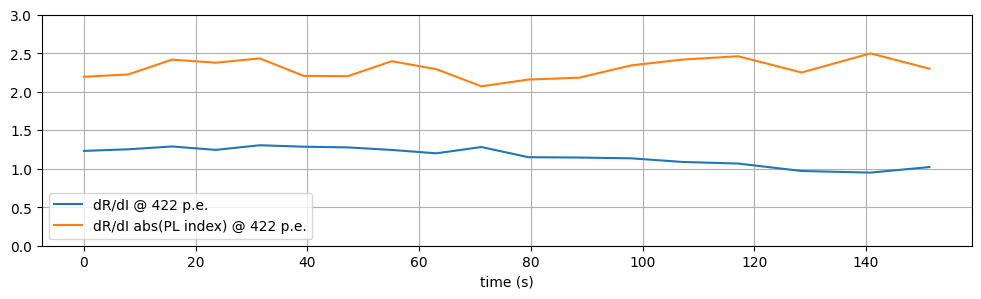

In [289]:
step = 1
if checklist.size > 20:
    step = int(checklist.size//20)

for jj in checklist[::step]:
    plt.figure(figsize=(12, 3))
    print(jj, f'max_lsc: {max_lsc[runlist==jj][0]:.2e}')
    test_run(jj)
    xt = cis['time'][cis['runnumber']==jj] - cis['time'][cis['runnumber']==jj].min()
    plt.plot(xt,
             cis['ZD_corrected_cosmics_rate_at_422_pe'][cis['runnumber']==jj], label='dR/dI @ 422 p.e.')

    plt.plot(xt,
             -cis['ZD_corrected_cosmics_spectral_index'][cis['runnumber']==jj], label='dR/dI abs(PL index) @ 422 p.e.')

    plt.grid()

    plt.ylim(0, 3)
    plt.xlabel('time (s)')
    plt.legend()
    plt.show()
    print()


## List of selected runs

In [290]:
good_dates.size

40

In [291]:
print()
print('Total number of runs:', good_runs.size, '(in', good_dates.size ,'nights)')
obs_hours = runsummary['elapsed_time'][mask].sum()/3600
print(f'Total observation time: {obs_hours:.2f} hours')
print()

good_dates = np.unique(rundate[mask])
for dd in good_dates:
    print(dd)
    print('--------')
    print('  ', runlist[mask & (rundate==dd)])
    print()


Total number of runs: 143 (in 40 nights)
Total observation time: 43.57 hours

20201118
--------
   [2929 2930 2931 2932 2933 2934]

20201119
--------
   [2949 2950 2959]

20201120
--------
   [2966 2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]

20201121
--------
   [2988 2989 2990 2991 2992]

20201122
--------
   [3004 3006 3007 3008 3009]

20201207
--------
   [3093 3094 3095 3096 3097]

20201211
--------
   [3169]

20201213
--------
   [3231 3232]

20201214
--------
   [3243 3244]

20201215
--------
   [3269 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279]

20201217
--------
   [3318 3319 3320 3321]

20201218
--------
   [3328 3329]

20201219
--------
   [3338 3339 3340]

20201220
--------
   [3355 3356]

20201221
--------
   [3373]

20210210
--------
   [3585 3586]

20210211
--------
   [3598 3599 3600 3601]

20210212
--------
   [3616]

20210213
--------
   [3631 3632 3633 3634 3635 3636]

20210215
--------
   [3672 3673 3674 3675 3676 3677 3678 3679]

20210216
-------

## List of selected run-wise (i.e., merged) DL1 files

In [292]:
# List of preferred DL1 directories (in order of preference):
dl1_dirlist = ["/fefs/aswg/data/real/DL1/YYYYMMDD/v0.10/tailcut84",
               "/fefs/aswg/data/real/DL1/YYYYMMDD/v0.9/tailcut84"]

for rr in good_runs:
    dd = rundate[runlist==rr][0]
    for ii, dl in enumerate(dl1_dirlist):
        dir = dl.replace('YYYYMMDD', str(dd))
        filename = dir+f'/dl1*Run{rr:05d}.h5'
        ff = glob.glob(filename)
        if len(ff) > 0:
            print(ff[0])
            break
        if ii == len(dl1_dirlist) - 1:
            print('Warning: file', filename, 'not found')

/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02929.h5
/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02930.h5
/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02931.h5
/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02932.h5
/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02933.h5
/fefs/aswg/data/real/DL1/20201118/v0.9/tailcut84/dl1_LST-1.Run02934.h5
/fefs/aswg/data/real/DL1/20201119/v0.9/tailcut84/dl1_LST-1.Run02949.h5
/fefs/aswg/data/real/DL1/20201119/v0.9/tailcut84/dl1_LST-1.Run02950.h5
/fefs/aswg/data/real/DL1/20201119/v0.9/tailcut84/dl1_LST-1.Run02959.h5
/fefs/aswg/data/real/DL1/20201120/v0.9/tailcut84/dl1_LST-1.Run02966.h5
/fefs/aswg/data/real/DL1/20201120/v0.9/tailcut84/dl1_LST-1.Run02967.h5
/fefs/aswg/data/real/DL1/20201120/v0.9/tailcut84/dl1_LST-1.Run02968.h5
/fefs/aswg/data/real/DL1/20201120/v0.9/tailcut84/dl1_LST-1.Run02969.h5
/fefs/aswg/data/real/DL1/20201120/v0.9/tailcut84/dl1_LST-1.Run02970.h5
/fefs/

/fefs/aswg/data/real/DL1/20220305/v0.9/tailcut84/dl1_LST-1.Run07274.h5
/fefs/aswg/data/real/DL1/20220305/v0.9/tailcut84/dl1_LST-1.Run07275.h5
/fefs/aswg/data/real/DL1/20220305/v0.9/tailcut84/dl1_LST-1.Run07276.h5
/fefs/aswg/data/real/DL1/20220305/v0.9/tailcut84/dl1_LST-1.Run07277.h5
/fefs/aswg/data/real/DL1/20220306/v0.9/tailcut84/dl1_LST-1.Run07301.h5


## List of NON-selected runs that pass all selections except the dR/dI rate selection:
This may be good candidates for data correction (via scaling the light in pixels before the cleaning)

In [293]:
not_so_bad_dates = np.unique(rundate[(~mask) & mask_no_drdi_rate_cut])

not_so_bad_obs_hours = runsummary['elapsed_time'][(~mask) & mask_no_drdi_rate_cut].sum()/3600
print()
print(f'Observation time: {not_so_bad_obs_hours:.2f} hours')
print()
for dd in not_so_bad_dates:
    print(dd)
    print('--------')
    print('  ', runlist[(~mask) & mask_no_drdi_rate_cut & (rundate==dd)])
    print()



Observation time: 7.19 hours

20201117
--------
   [2913 2914 2916 2917]

20201118
--------
   [2925]

20201119
--------
   [2952 2953 2954 2955 2956 2957]

20201122
--------
   [3005]

20210311
--------
   [3954]

20210314
--------
   [4027 4028 4029]

20210907
--------
   [6147 6148]

20210908
--------
   [6172]

20210909
--------
   [6193 6194 6195]

20210911
--------
   [6241 6242]

20220203
--------
   [6853]

